In [1]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [4]:
# File path
model_file = "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_x1_210_x2_270_y1_-20_y2_10.nc"

# Open and slice time
ds = xr.open_dataset(model_file).sel(time=slice("1979-01-01", "2024-12-31"))

# Convert CESM 'days since 1850-01-17' to datetime64
ds["time"] = xr.decode_cf(ds[["time"]]).time

# Variables to preprocess
varnames = ["TEMP", "photoC_TOT_zint_100m", "SSH", "HBLT", "Fe"]

# Function to remove monthly climatology (1980–2010) and quadratic trend
def deseason_detrend(da):
    # 1️⃣ Monthly climatology (1980–2010)
    clim = da.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
    anomalies = da.groupby("time.month") - clim

    # 2️⃣ Quadratic trend (full period)
    t = np.arange(anomalies.time.size)
    coeffs = np.polyfit(t, anomalies.mean("ens_LE").values, deg=2)
    trend = np.polyval(coeffs, t)

    return anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# Apply preprocessing for each variable
processed_vars = {}
for v in varnames:
    print(f"Processing {v} ...")
    processed_vars[v] = deseason_detrend(ds[v])

# Merge processed variables into one dataset
ds_processed = xr.Dataset(processed_vars)

# Add auxiliary coordinate
# ds_processed = ds_processed.assign_coords(month=("time", ds_processed["time"].dt.month))

# ✅ done
ds_processed = ds_processed.isel(ens_LE=0)
#units cm -> m
ds_processed['SSH']=ds_processed['SSH']/100
ds_processed['HBLT']=ds_processed['HBLT']/100
ds_processed['photoC_TOT_zint_100m']=ds_processed['photoC_TOT_zint_100m']*1000/8.32/10**7*100*100*86400
#LE NPP : mmol/m^3 cm/s (mmol/m^3 cm/s == nmol/cm^2/s)
# nmol/cm^2/s -> 1000/8.32/10^7 *100 *100 * 86400 -> mg / m^-2 / day
ds_processed



Processing TEMP ...
Processing photoC_TOT_zint_100m ...
Processing SSH ...
Processing HBLT ...
Processing Fe ...


<xarray.Dataset> Size: 31kB
Dimensions:               (time: 552)
Coordinates:
    ens_LE                int64 8B 0
  * time                  (time) object 4kB 1979-01-17 00:00:00 ... 2024-12-1...
    month                 (time) int64 4kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12
Data variables:
    TEMP                  (time) float64 4kB -0.9104 -0.8425 ... -0.5109 -0.3012
    photoC_TOT_zint_100m  (time) float64 4kB 24.24 12.48 ... -5.286 -39.01
    SSH                   (time) float64 4kB -0.05392 -0.05486 ... -0.006853
    HBLT                  (time) float64 4kB -0.0155 -1.494 ... -2.451 -3.148
    Fe                    (time) float64 4kB 4.118e-06 -1.618e-06 ... -7.231e-06

In [5]:
import xarray as xr
import os
import re

# Base directory
base_dir = "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_XRO/"

# Pattern for model files
files = sorted([f for f in os.listdir(base_dir) if f.endswith(".nc") and "XRO_input_LE_" in f])

# Variable name map (optional: if you want short names)
name_map = {
    "ENSO": "Nino34",
    "WWV": "WWV",
    "NPMM": "NPMM",
    "SPMM": "SPMM",
    "IOB": "IOB",
    "IOD": "IOD",
    "SIOD": "SIOD",
    "TNA": "TNA",
    "ATL3": "ATL3",
    "SASD": "SASD",
}

# Container for each variable
datasets = {}

for f in files:
    path = os.path.join(base_dir, f)
    # extract variable name from filename, e.g. XRO_input_LE_ENSO.nc → ENSO
    var = re.search(r"XRO_input_LE_(.*)\.nc", f).group(1)
    var_short = name_map.get(var, var)  # rename to match OBS if needed
    ds = xr.open_dataset(path)

    # ensure time consistency
    ds = ds.sel(time=slice("1979-01", "2024-12"))
    # pick the main variable automatically
    data_var = list(ds.data_vars)[0]
    datasets[var_short] = ds[data_var]

# Merge into one dataset
model_ds = xr.Dataset(datasets)

# Add month coordinate (like model_ds)
# model_ds = model_ds.assign_coords(month=("time", model_ds["time"].dt.month))

model_ds=model_ds.isel(ens_LE=0)
print(model_ds)

<xarray.Dataset> Size: 40kB
Dimensions:  (time: 552)
Coordinates:
    ens_LE   int64 8B 0
  * time     (time) object 4kB 1979-01-17 00:00:00 ... 2024-12-17 00:00:00
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    ATL3     (time) float32 2kB ...
    Nino34   (time) float32 2kB ...
    IOB      (time) float32 2kB ...
    IOD      (time) float64 4kB ...
    NPMM     (time) float32 2kB ...
    SASD     (time) float64 4kB ...
    SIOD     (time) float64 4kB ...
    SPMM     (time) float32 2kB ...
    TNA      (time) float32 2kB ...
    WWV      (time) float64 4kB ...


In [6]:
# removing monthly climatology (1980~2010)
# removing quadratic trend (all period)

# Variables to skip. Those dipole variables are already preprocessed
skip_vars = ["IOD", "SIOD", "SASD"]

# Create an empty container for processed variables
processed_vars = {}

for var in model_ds.data_vars:
    da = model_ds[var]

    if var in skip_vars:
        # Skip preprocessing for these
        processed_vars[var] = da
        print(f"Skipping preprocessing for {var}")
        continue

    # 1️⃣ Remove monthly climatology (1980–2010)
    clim = da.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
    anomalies = da.groupby("time.month") - clim

    # 2️⃣ Remove quadratic trend (over full time)
    t = np.arange(anomalies.time.size)
    coeffs = np.polyfit(t, anomalies.values, deg=2)
    trend = np.polyval(coeffs, t)
    detrended = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

    processed_vars[var] = detrended.astype(np.float32)
    print(f"Processed {var}")

# Merge all processed variables back into one dataset
model_ds_processed = xr.Dataset(processed_vars, coords={"time": model_ds.time})
# model_ds_processed = model_ds_processed.assign_coords(month=("time", model_ds.time.dt.month))

# and units (cm -> m)
model_ds_processed['WWV']=model_ds_processed['WWV']/100

# model_ds_processed = model_ds_processed.rename_vars({
#     "ALT3": "ATL3",
# })
model_ds_processed


Processed ATL3
Processed Nino34
Processed IOB
Skipping preprocessing for IOD
Processed NPMM
Skipping preprocessing for SASD
Skipping preprocessing for SIOD
Processed SPMM
Processed TNA
Processed WWV


<xarray.Dataset> Size: 38kB
Dimensions:  (time: 552)
Coordinates:
    ens_LE   int64 8B 0
  * time     (time) object 4kB 1979-01-17 00:00:00 ... 2024-12-17 00:00:00
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    ATL3     (time) float32 2kB 0.05102 -0.2335 -0.3377 ... -0.4495 -0.3308
    Nino34   (time) float32 2kB -1.743 -1.283 -0.688 ... -0.2806 -0.02884
    IOB      (time) float32 2kB 0.02841 -0.08239 -0.2231 ... -0.1871 -0.04754
    IOD      (time) float64 4kB ...
    NPMM     (time) float32 2kB 0.2315 -0.009068 0.3884 ... -0.08224 0.2926
    SASD     (time) float64 4kB ...
    SIOD     (time) float64 4kB ...
    SPMM     (time) float32 2kB -0.4884 -0.2366 -0.2786 ... -0.427 -0.3383
    TNA      (time) float32 2kB 0.002883 0.06056 -0.1877 ... -0.451 -0.1461
    WWV      (time) float32 2kB 0.04565 4.731 7.247 8.029 ... 8.466 8.747 12.43

In [7]:
model_all = xr.merge([model_ds_processed, ds_processed])
model_all

<xarray.Dataset> Size: 60kB
Dimensions:               (time: 552)
Coordinates:
    ens_LE                int64 8B 0
  * time                  (time) object 4kB 1979-01-17 00:00:00 ... 2024-12-1...
    month                 (time) int64 4kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12
Data variables: (12/15)
    ATL3                  (time) float32 2kB 0.05102 -0.2335 ... -0.4495 -0.3308
    Nino34                (time) float32 2kB -1.743 -1.283 ... -0.2806 -0.02884
    IOB                   (time) float32 2kB 0.02841 -0.08239 ... -0.04754
    IOD                   (time) float64 4kB ...
    NPMM                  (time) float32 2kB 0.2315 -0.009068 ... 0.2926
    SASD                  (time) float64 4kB ...
    ...                    ...
    WWV                   (time) float32 2kB 0.04565 4.731 7.247 ... 8.747 12.43
    TEMP                  (time) float64 4kB -0.9104 -0.8425 ... -0.5109 -0.3012
    photoC_TOT_zint_100m  (time) float64 4kB 24.24 12.48 ... -5.286 -39.01
    SSH                   (time) float64 4kB -0.05392 -0.05486 ... -0.006853
    HBLT                  (time) float64 4kB -0.0155 -1.494 ... -2.451 -3.148
    Fe                    (time) float64 4kB 4.118e-06 -1.618e-06 ... -7.231e-06

In [8]:
import pandas as pd

model_all = xr.merge([model_ds_processed, ds_processed])
model_all = model_all.rename_vars({
    "TEMP": "SST",
    "photoC_TOT_zint_100m": "NPP",
    "HBLT": "MLD"
})

# --- Convert time to datetime64 if not already ---
if (
    "cftime" in str(type(model_all.time.values[0]))
    or "CFTimeIndex" in str(type(model_all.indexes.get("time", None)))
):
    model_all["time"] = model_all.indexes["time"].to_datetimeindex()
elif not pd.api.types.is_datetime64_any_dtype(model_all.time):
    model_all = xr.decode_cf(model_all)

# --- Create target obs-style time axis (1979-01-01 → 2024-12-01) ---
obs_time = pd.date_range("1979-01-01", "2024-12-01", freq="MS")

# --- Ensure same length before assigning ---
n_model = model_all.sizes["time"]
n_obs = len(obs_time)
n_min = min(n_model, n_obs)

model_all = model_all.isel(time=slice(0, n_min))
obs_time = obs_time[:n_min]

# --- Replace with new monthly timestamps ---
model_all = model_all.assign_coords(time=("time", obs_time))


model_all


<xarray.Dataset> Size: 60kB
Dimensions:  (time: 552)
Coordinates:
    ens_LE   int64 8B 0
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
Data variables: (12/15)
    ATL3     (time) float32 2kB 0.05102 -0.2335 -0.3377 ... -0.4495 -0.3308
    Nino34   (time) float32 2kB -1.743 -1.283 -0.688 ... -0.2806 -0.02884
    IOB      (time) float32 2kB 0.02841 -0.08239 -0.2231 ... -0.1871 -0.04754
    IOD      (time) float64 4kB ...
    NPMM     (time) float32 2kB 0.2315 -0.009068 0.3884 ... -0.08224 0.2926
    SASD     (time) float64 4kB ...
    ...       ...
    WWV      (time) float32 2kB 0.04565 4.731 7.247 8.029 ... 8.466 8.747 12.43
    SST      (time) float64 4kB -0.9104 -0.8425 -0.6215 ... -0.5109 -0.3012
    NPP      (time) float64 4kB 24.24 12.48 -5.085 ... -56.56 -5.286 -39.01
    SSH      (time) float64 4kB -0.05392 -0.05486 ... -0.01403 -0.006853
    MLD      (time) float64 4kB -0.0155 -1.494 -0.06168 ... 1.961 -2.451 -3.148
    Fe       (time) float64 4kB 4.118e-06 -1.618e-06 ... -4.659e-06 -7.231e-06

In [9]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

In [10]:
# Choose variables
model_all

model_XRO_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
model_NRO_ds = model_all[['Nino34', 'WWV']]

model_XRO_NPP_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']]
model_NRO_NPP_ds = model_all[['Nino34', 'WWV', 'NPP']]

model_XRO_NPP_Fe_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']]
model_NRO_NPP_Fe_ds = model_all[['Nino34', 'WWV', 'NPP', 'Fe']]

model_XRO_NPP_SST_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'NPP']]
model_NRO_NPP_SST_ds = model_all[['Nino34', 'WWV', 'SST', 'NPP']]

model_XRO_NPP_SST_Fe_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'NPP', 'Fe']]
model_NRO_NPP_SST_Fe_ds = model_all[['Nino34', 'WWV', 'SST', 'NPP', 'Fe']]

model_XRO_ALL_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'SSH', 'MLD', 'NPP']]
model_NRO_ALL_ds = model_all[['Nino34', 'WWV', 'SST', 'SSH', 'MLD', 'NPP']]

model_XRO_ALL_Fe_ds = model_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'SSH', 'MLD', 'NPP']]
model_NRO_ALL_Fe_ds = model_all[['Nino34', 'WWV', 'SST', 'SSH', 'MLD', 'NPP']]

### 5.1 IN-sample XRO-NPP correlation and RMSE skills
Train model using 1979-2024
Forecast verification using 1979-2024

In [11]:
slice_train = slice('1979-01', '2024-12')
slice_verif = slice('1979-01', '2024-12')
XRO_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
XRO_ann = XRO(ncycle=12, ac_order=0, is_forward=True)
XRO_NPP_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)


In [12]:

fit_XRO_train = XRO_ac1.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_insample = calc_forecast_skill(XRO_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_insample = calc_forecast_skill(NRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac1.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_insample = calc_forecast_skill(LRO_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

In [13]:
ccr_XRO_Nino34_ds = xcorr(model_XRO_NPP_ds, model_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(model_XRO_NPP_ds, model_XRO_NPP_ds['NPP'], maxlags=36)

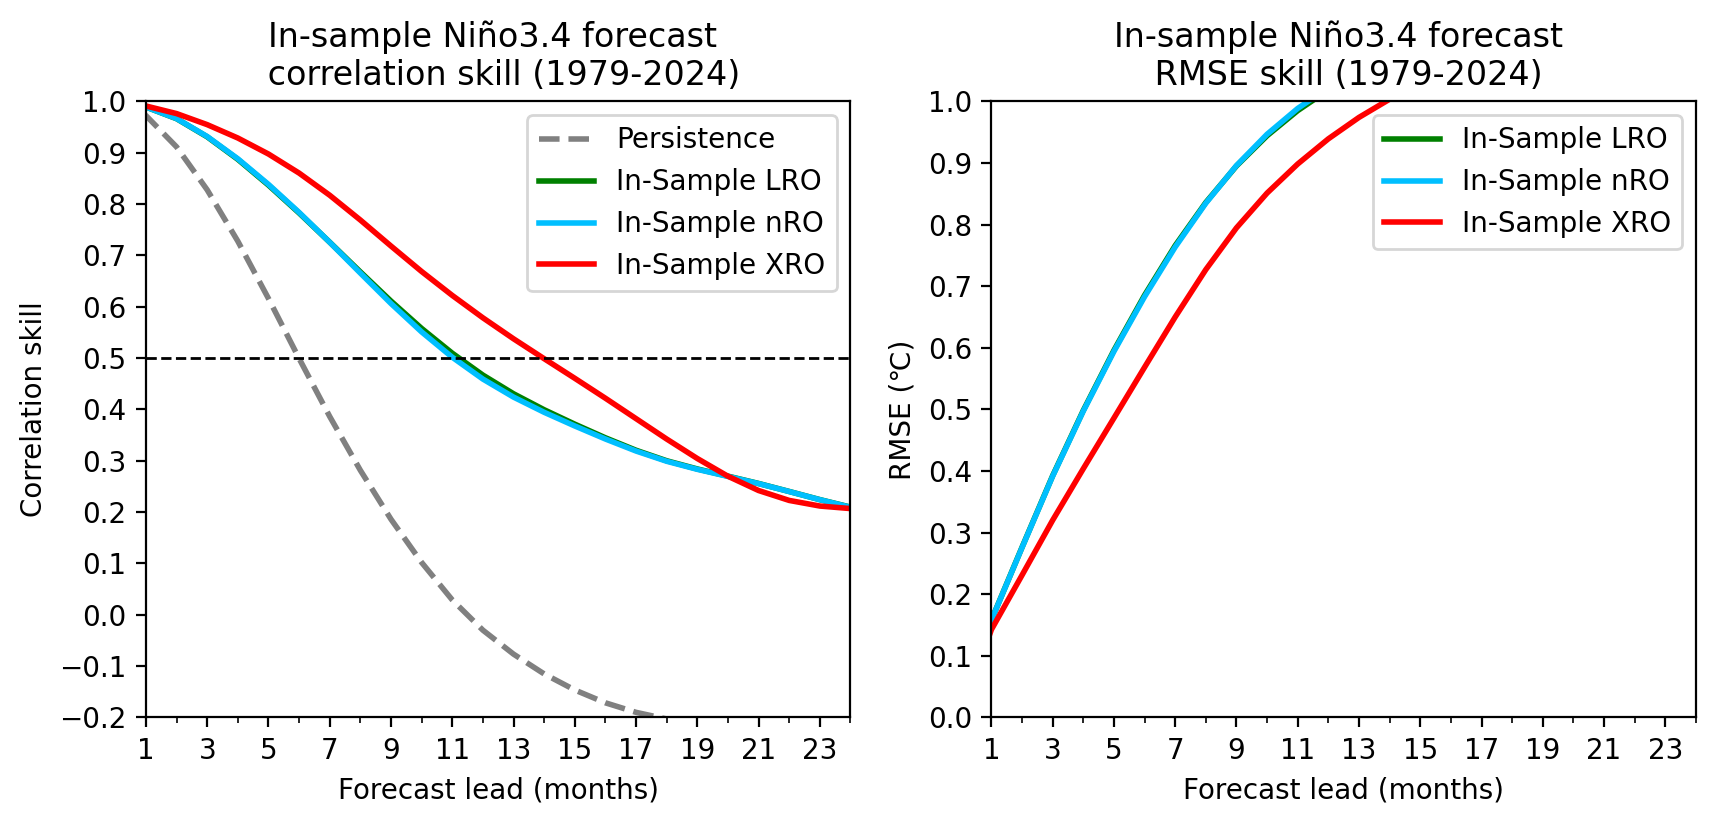

In [14]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO', c='green', lw=2)
acc_NRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO', c='deepskyblue', lw=2)
acc_XRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO', c='green', lw=2)
rmse_NRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO', c='deepskyblue', lw=2)
rmse_XRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


In [15]:
fit_XRO_ann_train = XRO_ann.fit_matrix(model_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_XRO_ann_train, init_ds=model_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_ann_insample = calc_forecast_skill(XRO_ann_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_ann_insample = calc_forecast_skill(XRO_ann_insample_fcst, model_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_ann_train = XRO_ann.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_NRO_ann_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_ann_insample = calc_forecast_skill(NRO_ann_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_ann_insample = calc_forecast_skill(NRO_ann_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ann.fit_matrix(model_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_ann_train = XRO_ann.fit_matrix(model_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_LRO_ann_train, init_ds=model_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_ann_insample = calc_forecast_skill(LRO_ann_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_ann_insample = calc_forecast_skill(LRO_ann_insample_fcst, model_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

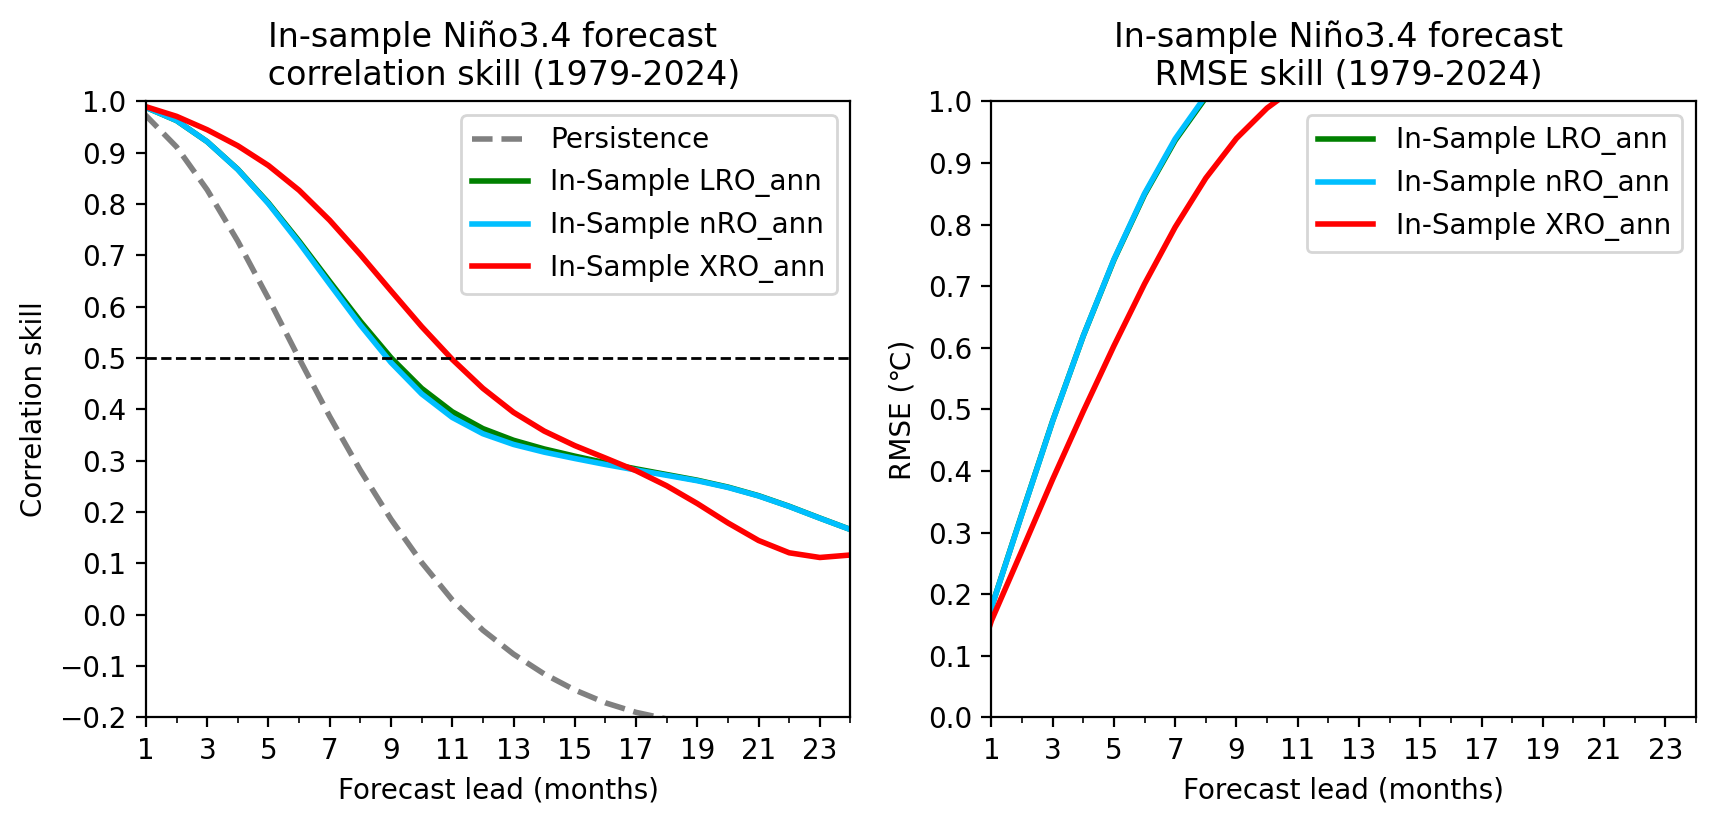

In [16]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO_ann', c='green', lw=2)
acc_NRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO_ann', c='deepskyblue', lw=2)
acc_XRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO_ann', c='green', lw=2)
rmse_NRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO_ann', c='deepskyblue', lw=2)
rmse_XRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO_ann', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


In [17]:
ccr_XRO_Nino34_ds = xcorr(model_XRO_NPP_ds, model_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(model_XRO_NPP_ds, model_XRO_NPP_ds['NPP'], maxlags=36)

In [18]:
fit_XRO_NPP_train = XRO_NPP_ac1.fit_matrix(model_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_XRO_NPP_train, init_ds=model_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_NPP_train = XRO_NPP_ac1.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_NRO_NPP_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_insample = calc_forecast_skill(NRO_NPP_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_insample = calc_forecast_skill(NRO_NPP_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_NPP_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_train = XRO_NPP_ac1.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_LRO_NPP_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_insample = calc_forecast_skill(LRO_NPP_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_insample = calc_forecast_skill(LRO_NPP_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

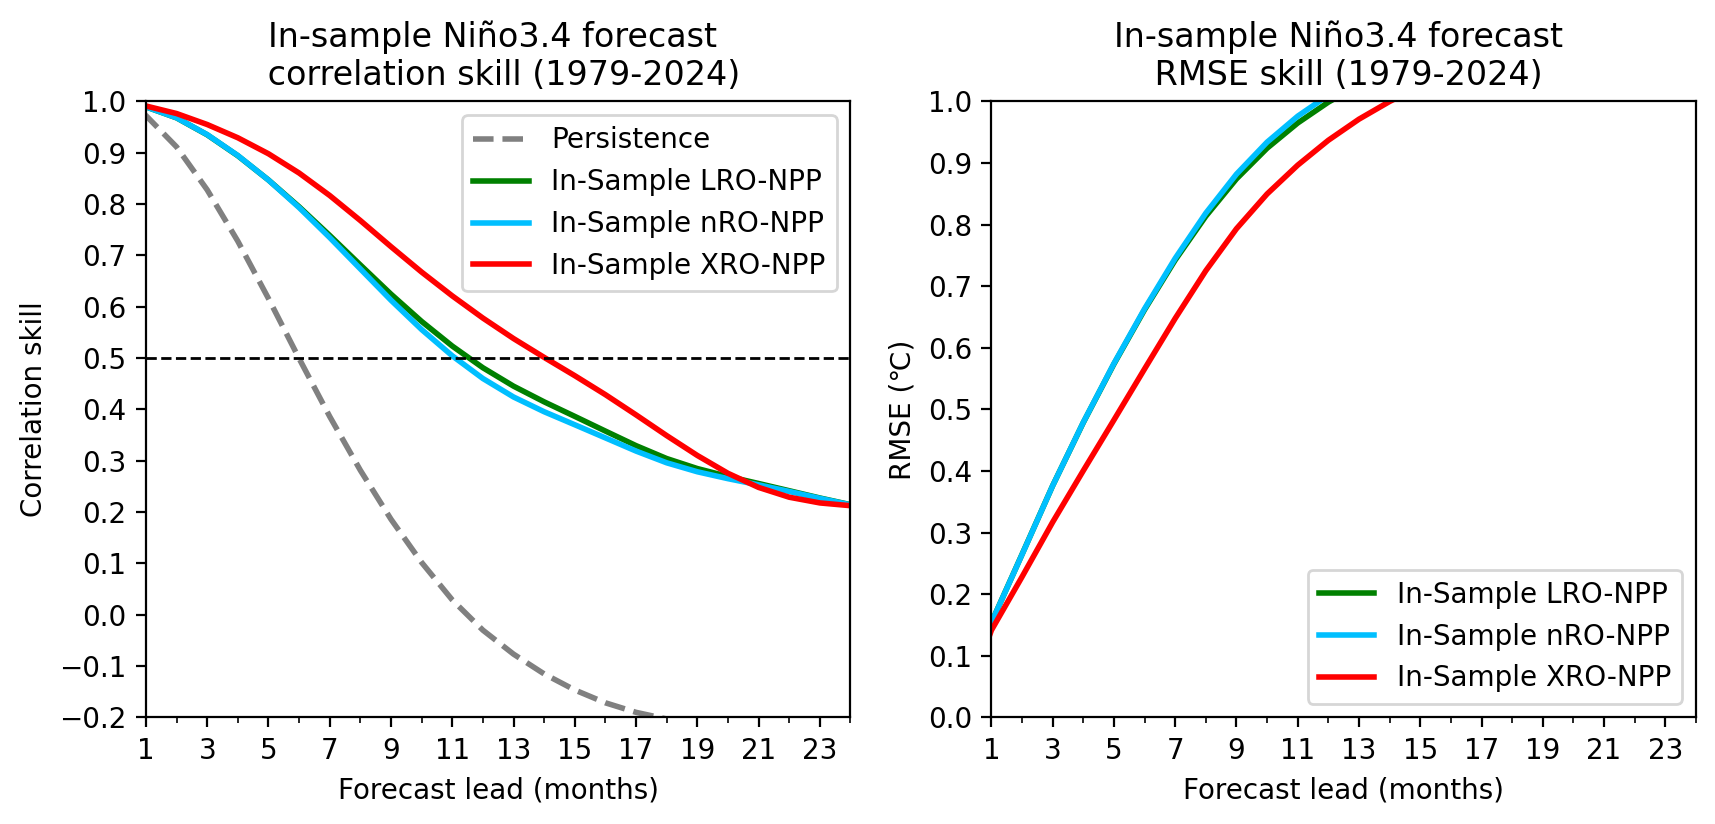

In [19]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


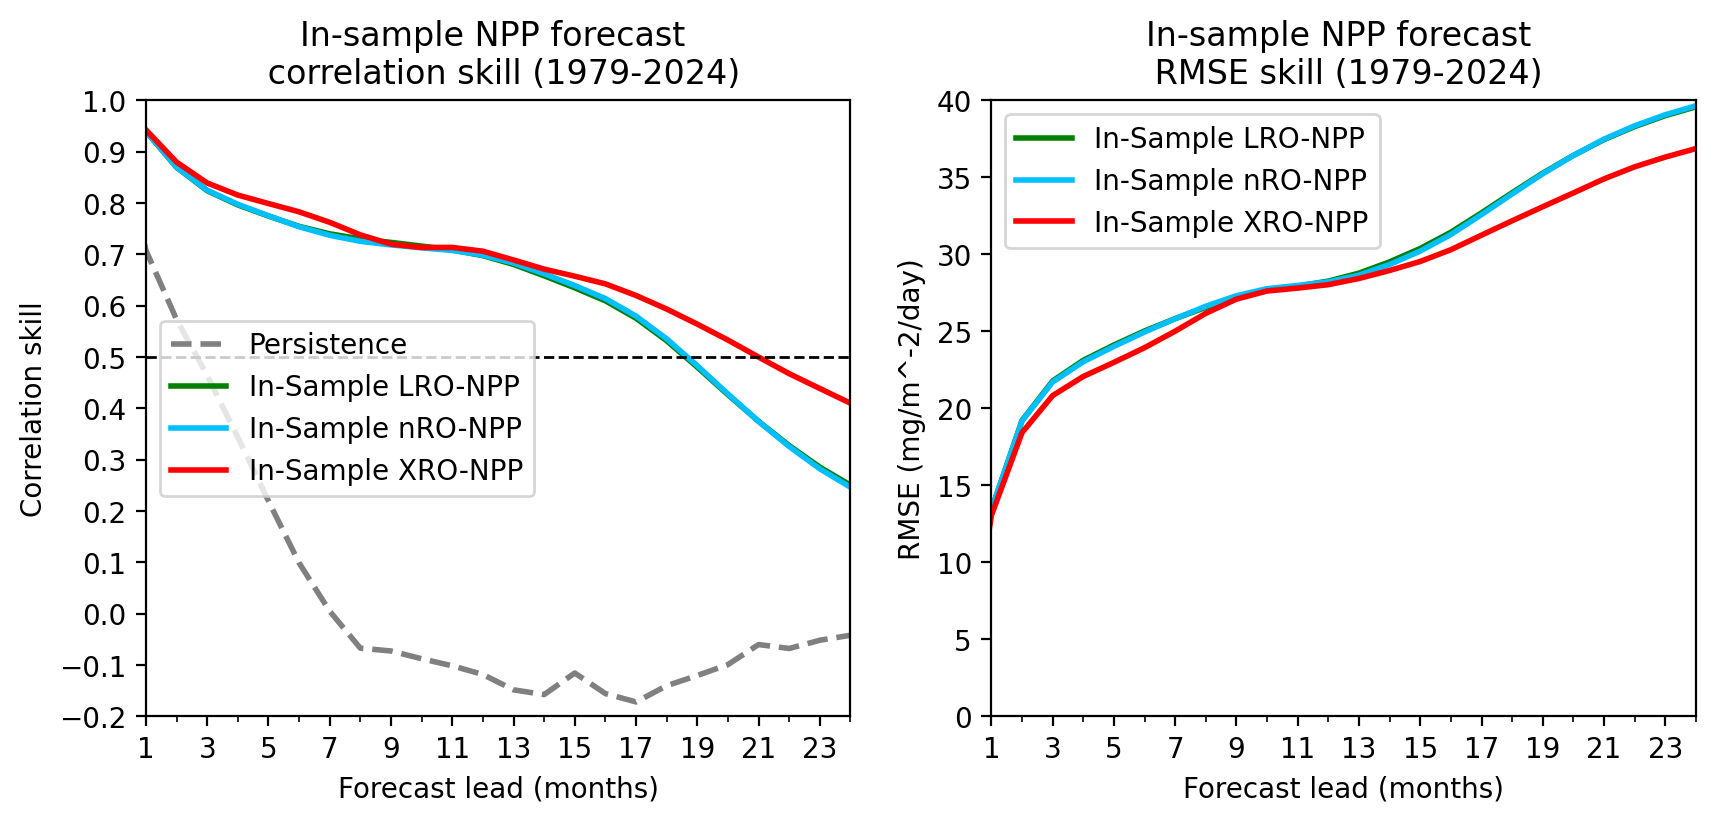

In [20]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)

ax.set_ylabel('{0} (mg/m^-2/day)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [21]:
XRO_NPP_Fe_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
fit_XRO_NPP_Fe_train = XRO_NPP_Fe_ac1.fit_matrix(model_XRO_NPP_Fe_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_Fe_insample_fcst = XRO_NPP_Fe_ac1.reforecast(fit_ds=fit_XRO_NPP_Fe_train, init_ds=model_XRO_NPP_Fe_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_Fe_insample = calc_forecast_skill(XRO_NPP_Fe_insample_fcst, model_XRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_Fe_insample = calc_forecast_skill(XRO_NPP_Fe_insample_fcst, model_XRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_NPP_Fe_train = XRO_NPP_Fe_ac1.fit_matrix(model_NRO_NPP_Fe_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_Fe_insample_fcst = XRO_NPP_Fe_ac1.reforecast(fit_ds=fit_NRO_NPP_Fe_train, init_ds=model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_Fe_insample = calc_forecast_skill(NRO_NPP_Fe_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_Fe_insample = calc_forecast_skill(NRO_NPP_Fe_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP_Fe = XRO_ac1.fit_matrix(model_NRO_NPP_Fe_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_Fe_train = XRO_NPP_Fe_ac1.fit_matrix(model_NRO_NPP_Fe_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_Fe_insample_fcst = XRO_NPP_Fe_ac1.reforecast(fit_ds=fit_LRO_NPP_Fe_train, init_ds=model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_Fe_insample = calc_forecast_skill(LRO_NPP_Fe_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_Fe_insample = calc_forecast_skill(LRO_NPP_Fe_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

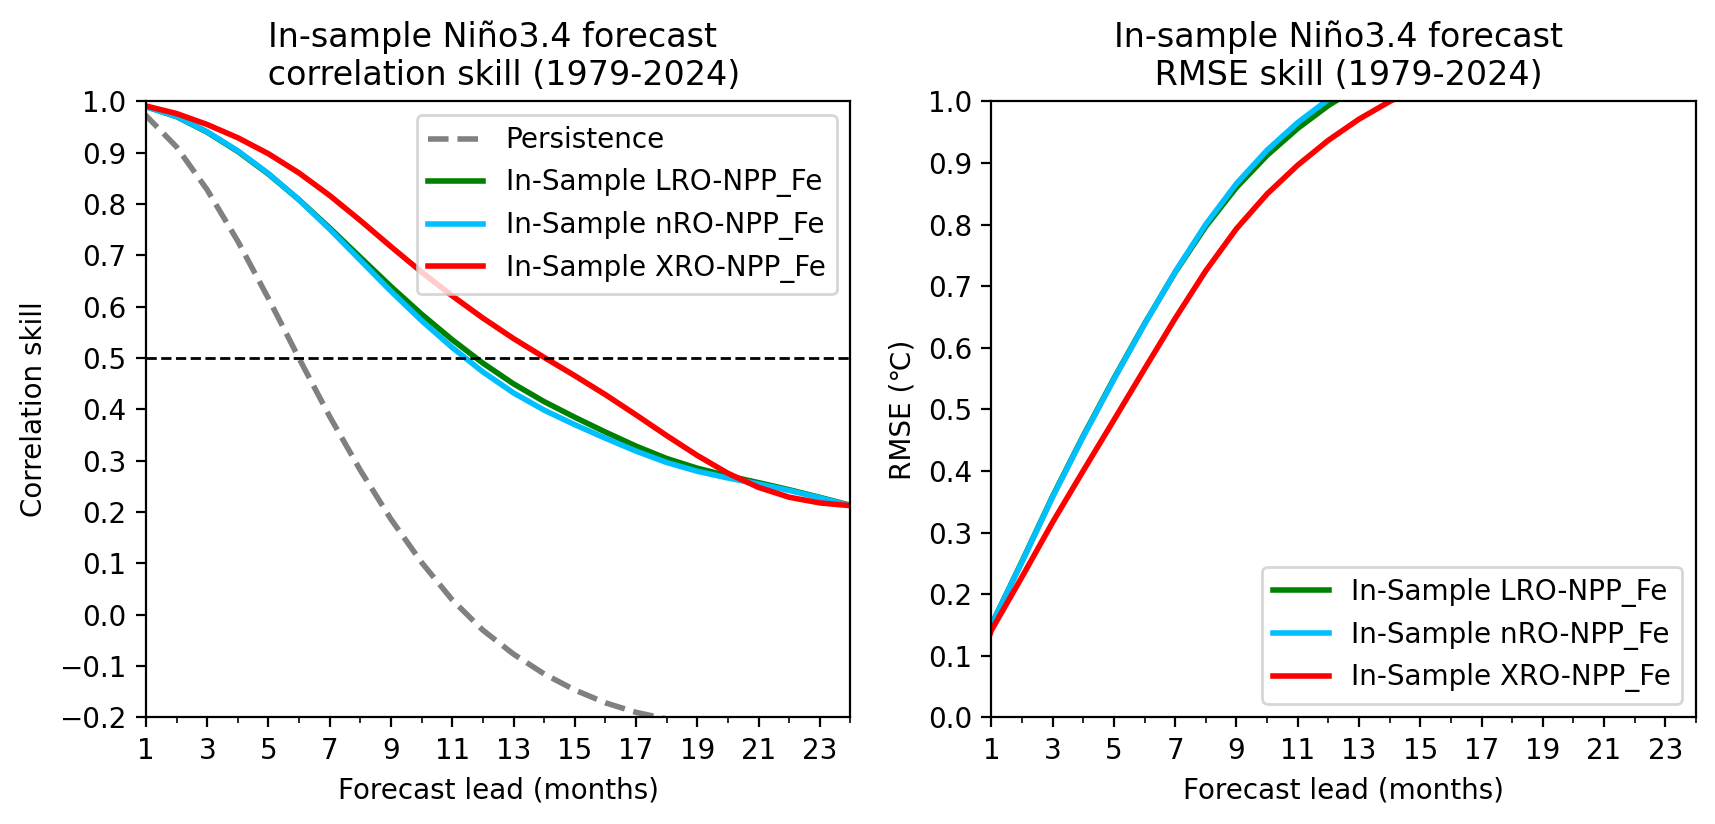

In [22]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe', c='green', lw=2)
acc_NRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe', c='deepskyblue', lw=2)
acc_XRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe', c='green', lw=2)
rmse_NRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe', c='deepskyblue', lw=2)
rmse_XRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


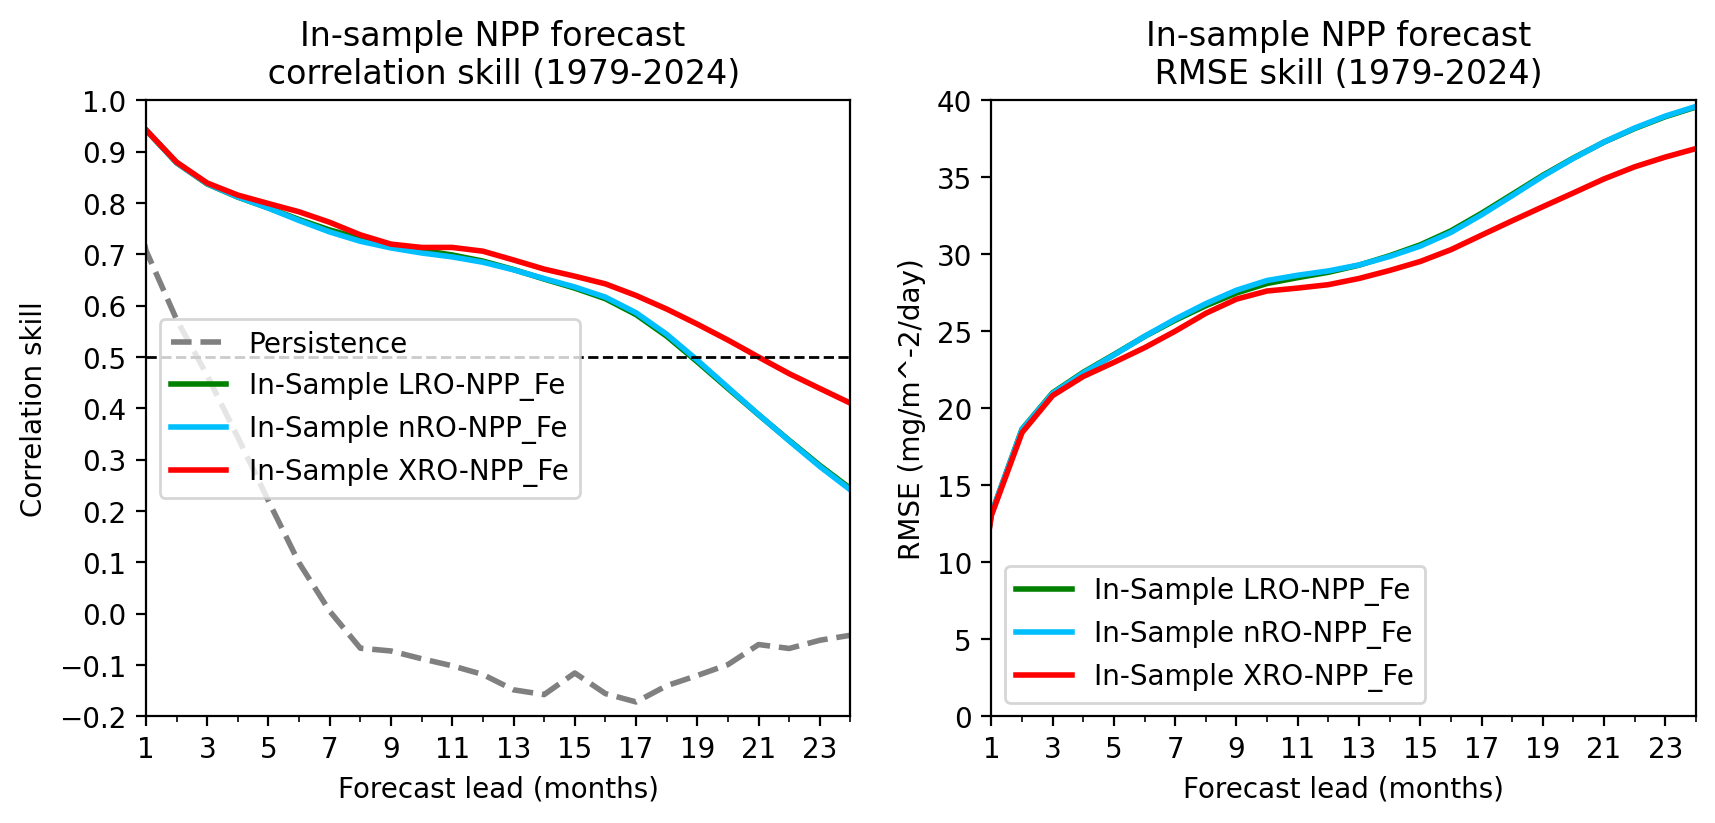

In [23]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe', c='green', lw=2)
acc_NRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe', c='deepskyblue', lw=2)
acc_XRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe', c='green', lw=2)
rmse_NRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe', c='deepskyblue', lw=2)
rmse_XRO_NPP_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe', c='red', lw=2)

ax.set_ylabel('{0} (mg/m^-2/day)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [62]:
XRO_NPP_Fe_ann = XRO(ncycle=12, ac_order=0, is_forward=True)
fit_XRO_NPP_Fe_ann_train = XRO_NPP_Fe_ann.fit_matrix(model_XRO_NPP_Fe_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_Fe_ann_insample_fcst = XRO_NPP_Fe_ann.reforecast(fit_ds=fit_XRO_NPP_Fe_ann_train, init_ds=model_XRO_NPP_Fe_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_Fe_ann_insample = calc_forecast_skill(XRO_NPP_Fe_ann_insample_fcst, model_XRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_Fe_ann_insample = calc_forecast_skill(XRO_NPP_Fe_ann_insample_fcst, model_XRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_NPP_Fe_ann_train = XRO_NPP_Fe_ann.fit_matrix(model_NRO_NPP_Fe_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_Fe_ann_insample_fcst = XRO_NPP_Fe_ann.reforecast(fit_ds=fit_NRO_NPP_Fe_ann_train, init_ds=model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_Fe_ann_insample = calc_forecast_skill(NRO_NPP_Fe_ann_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_Fe_ann_insample = calc_forecast_skill(NRO_NPP_Fe_ann_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP_Fe = XRO_ann.fit_matrix(model_NRO_NPP_Fe_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_Fe_ann_train = XRO_NPP_Fe_ann.fit_matrix(model_NRO_NPP_Fe_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_Fe_ann_insample_fcst = XRO_NPP_Fe_ann.reforecast(fit_ds=fit_LRO_NPP_Fe_ann_train, init_ds=model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_Fe_ann_insample = calc_forecast_skill(LRO_NPP_Fe_ann_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_Fe_ann_insample = calc_forecast_skill(LRO_NPP_Fe_ann_insample_fcst, model_NRO_NPP_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], inactive=[]
X_active shape: (13, 552), total X shape: (13, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 552), total X shape: (12, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 552), total X shape: (11, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 552), total X shape: (11, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 552), total X shape: (11, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 552), total X shape: (12, 552)
Y shape: (1, 552)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 552), total X shape: (11, 552)
Y shape:

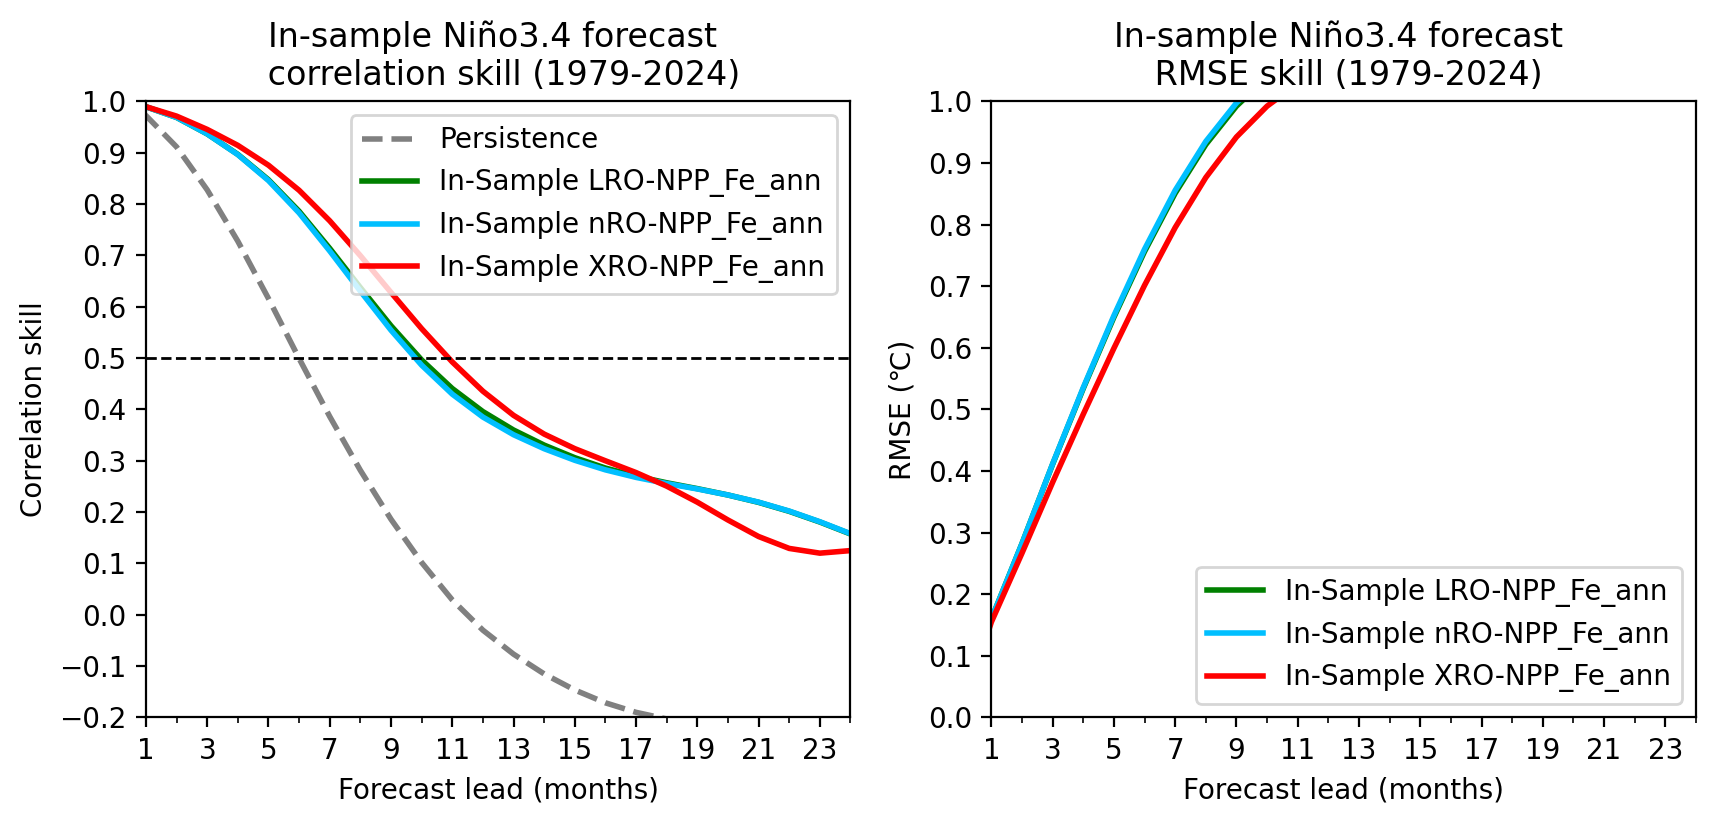

In [63]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe_ann', c='green', lw=2)
acc_NRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe_ann', c='green', lw=2)
rmse_NRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe_ann', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


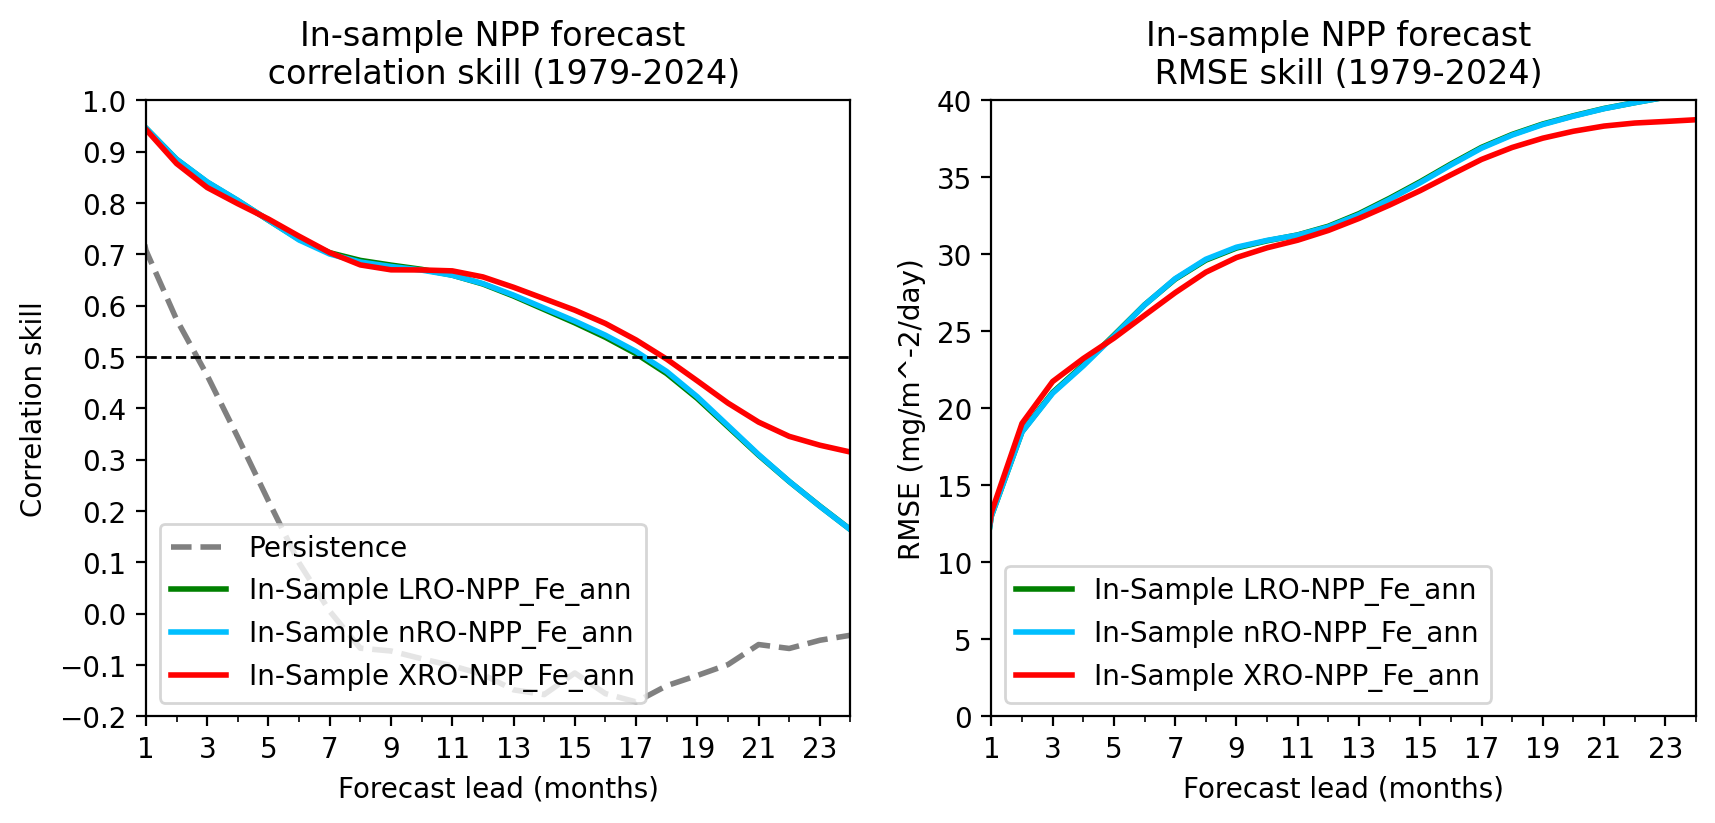

In [64]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe_ann', c='green', lw=2)
acc_NRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_Fe_ann', c='green', lw=2)
rmse_NRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_Fe_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_Fe_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_Fe_ann', c='red', lw=2)

ax.set_ylabel('{0} (mg/m^-2/day)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [24]:
XRO_NPP_ann = XRO(ncycle=12, ac_order=0, is_forward=True)


In [25]:

fit_XRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(model_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])
XRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_XRO_NPP_ann_train, init_ds=model_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_ann_insample = calc_forecast_skill(XRO_NPP_ann_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_ann_insample = calc_forecast_skill(XRO_NPP_ann_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

In [26]:

fit_NRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_NRO_NPP_ann_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_ann_insample = calc_forecast_skill(NRO_NPP_ann_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_ann_insample = calc_forecast_skill(NRO_NPP_ann_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

In [27]:

fit_LRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_LRO_NPP_ann_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_ann_insample = calc_forecast_skill(LRO_NPP_ann_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_ann_insample = calc_forecast_skill(LRO_NPP_ann_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))



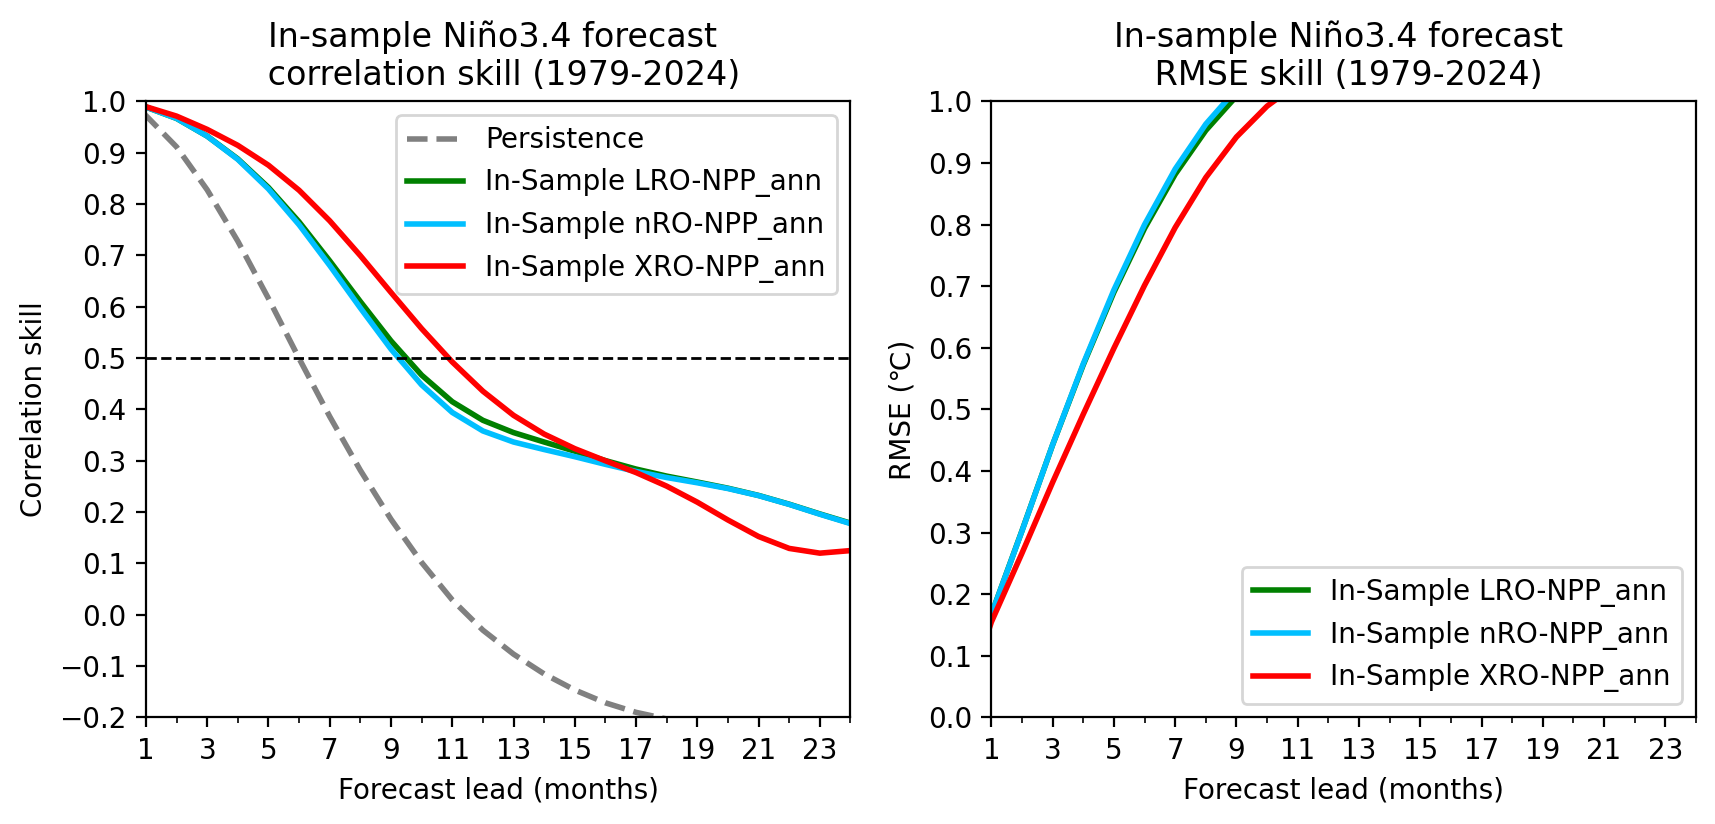

In [28]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
acc_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
rmse_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


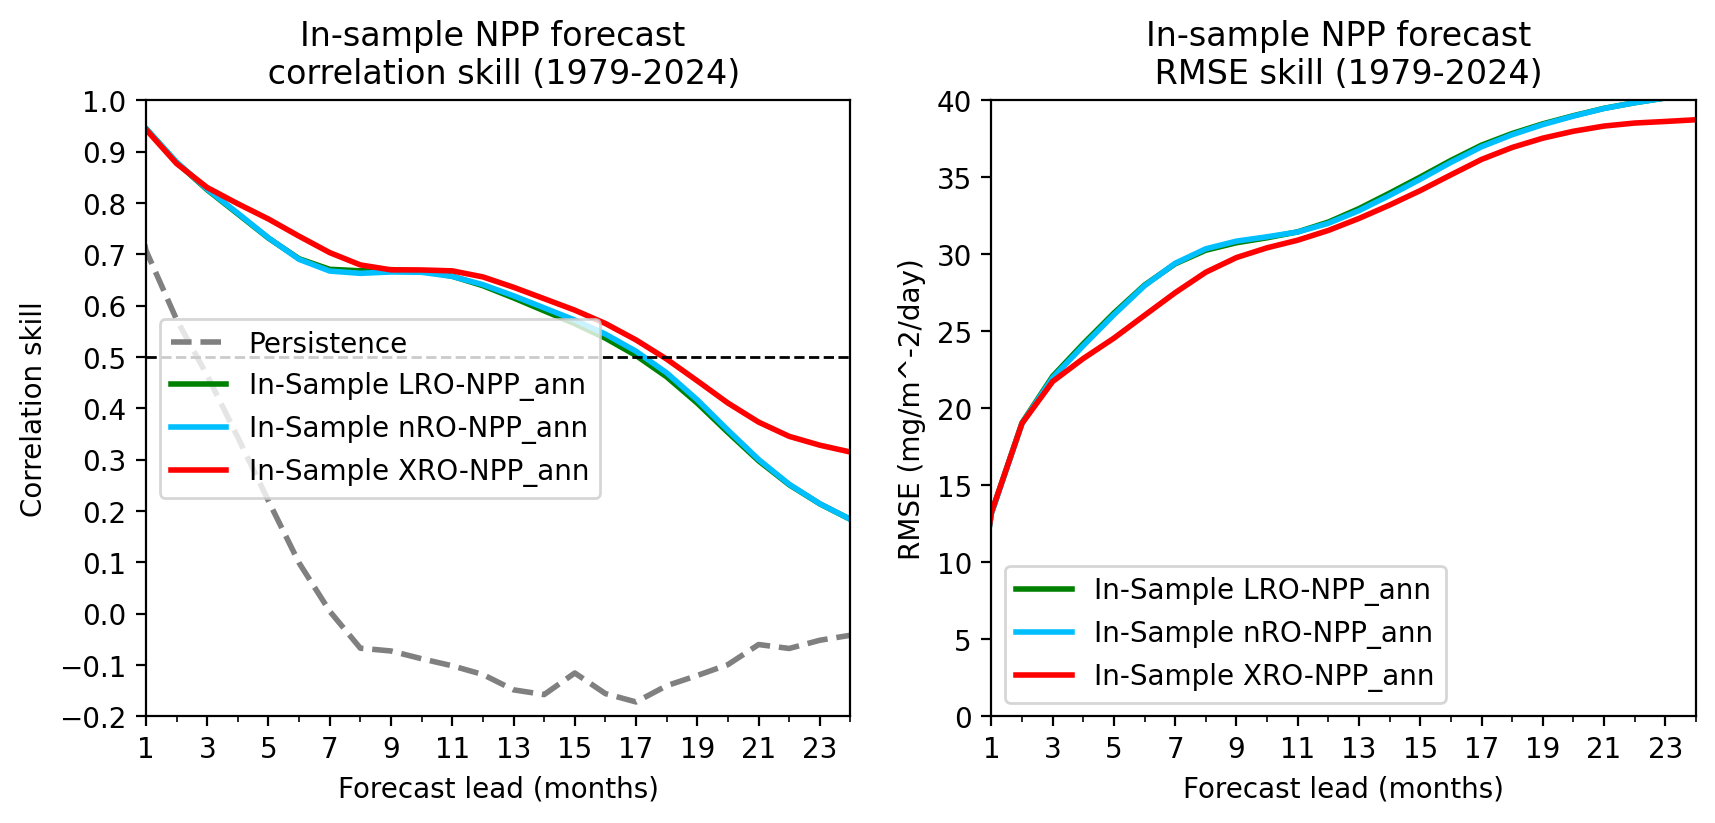

In [29]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
acc_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
rmse_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)

ax.set_ylabel('{0} (mg/m^-2/day)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [30]:
XRO_NPP_ac2 = XRO(ncycle=12, ac_order=2, is_forward=True)


In [31]:

fit_XRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(model_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])
XRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_XRO_NPP_ac2_train, init_ds=model_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_ac2_insample = calc_forecast_skill(XRO_NPP_ac2_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_ac2_insample = calc_forecast_skill(XRO_NPP_ac2_insample_fcst, model_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

In [32]:

fit_NRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_NRO_NPP_ac2_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_ac2_insample = calc_forecast_skill(NRO_NPP_ac2_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_ac2_insample = calc_forecast_skill(NRO_NPP_ac2_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

In [33]:

fit_LRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(model_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_LRO_NPP_ac2_train, init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_ac2_insample = calc_forecast_skill(LRO_NPP_ac2_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_ac2_insample = calc_forecast_skill(LRO_NPP_ac2_insample_fcst, model_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))



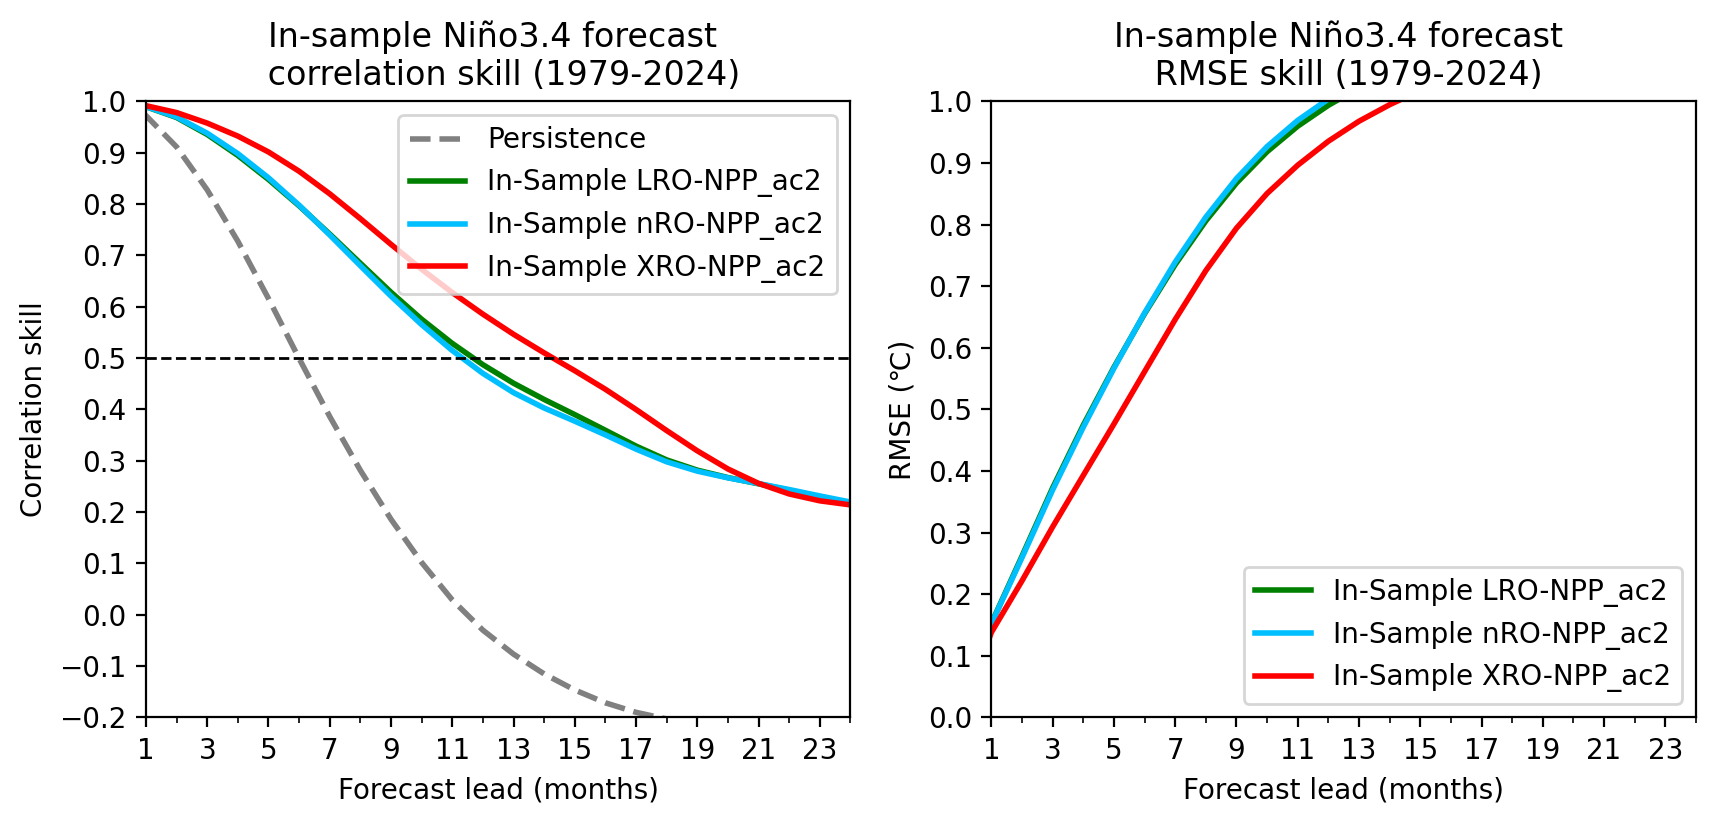

In [34]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
acc_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
acc_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
rmse_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
rmse_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


Text(0.5, 0, 'Forecast lead (months)')

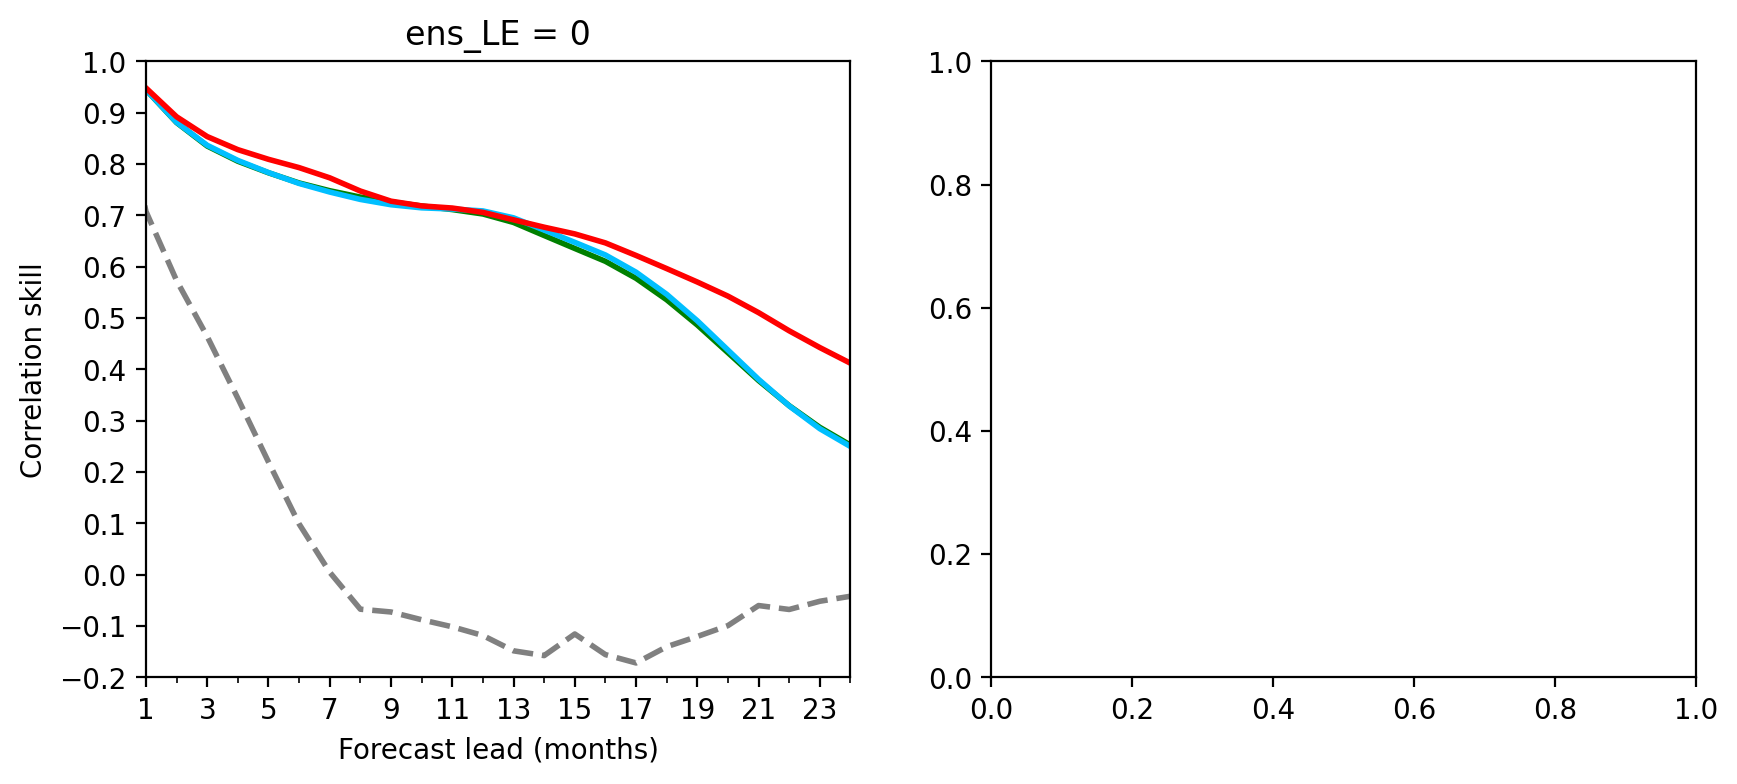

In [35]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
acc_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
acc_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')

In [36]:
XRO_NPP_SST_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(model_XRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, init_ds=model_XRO_NPP_SST_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, model_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, model_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(model_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, init_ds=model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_NPP_SST_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(model_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, init_ds=model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

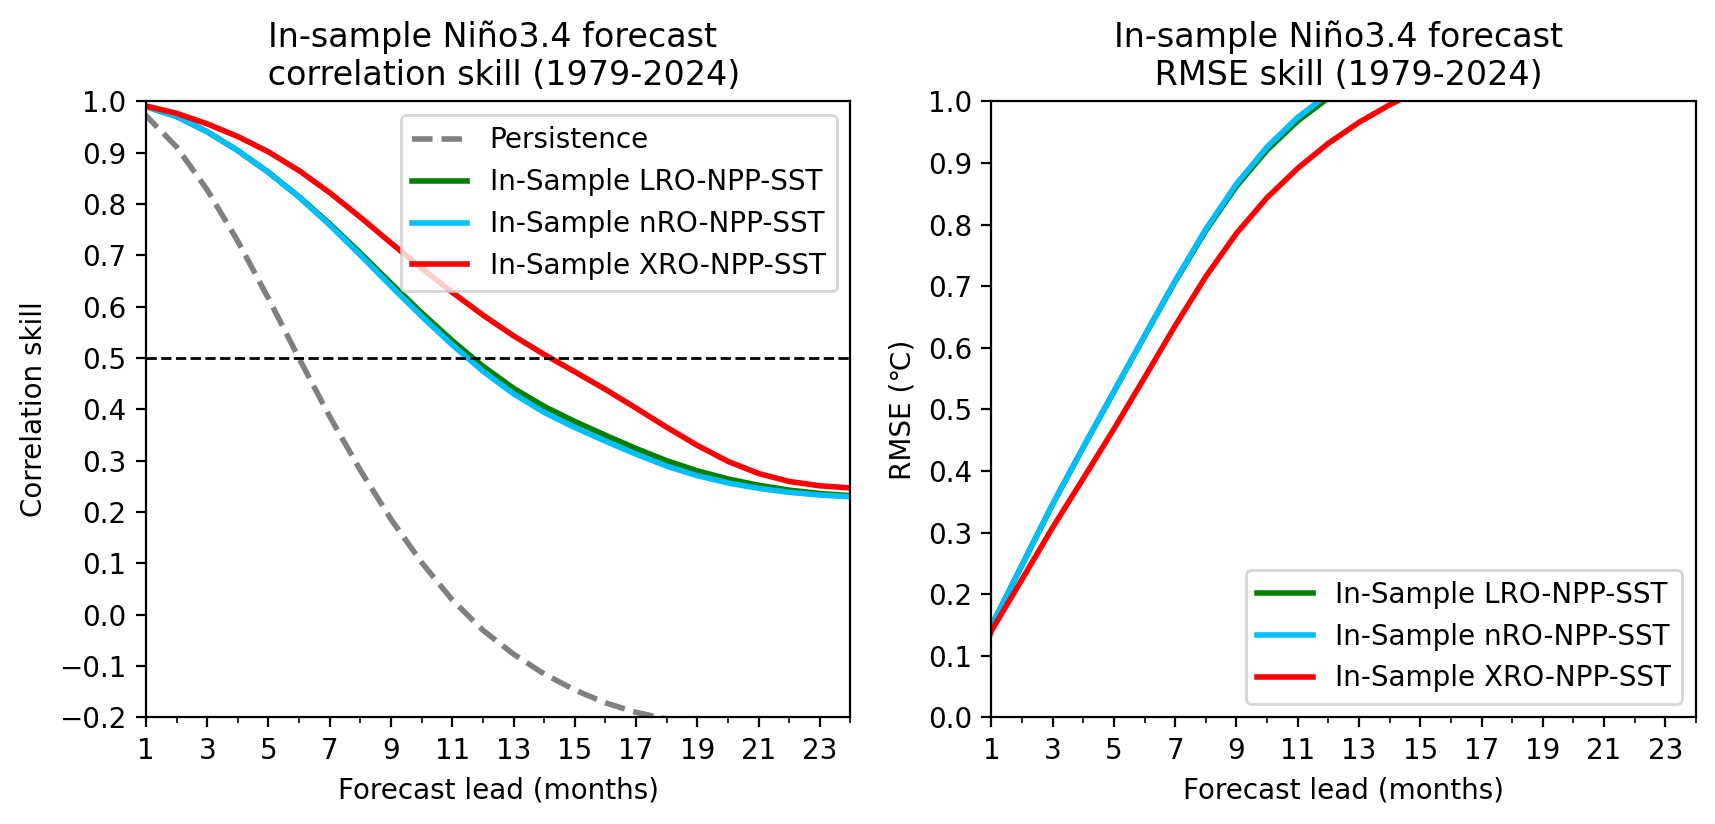

In [37]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


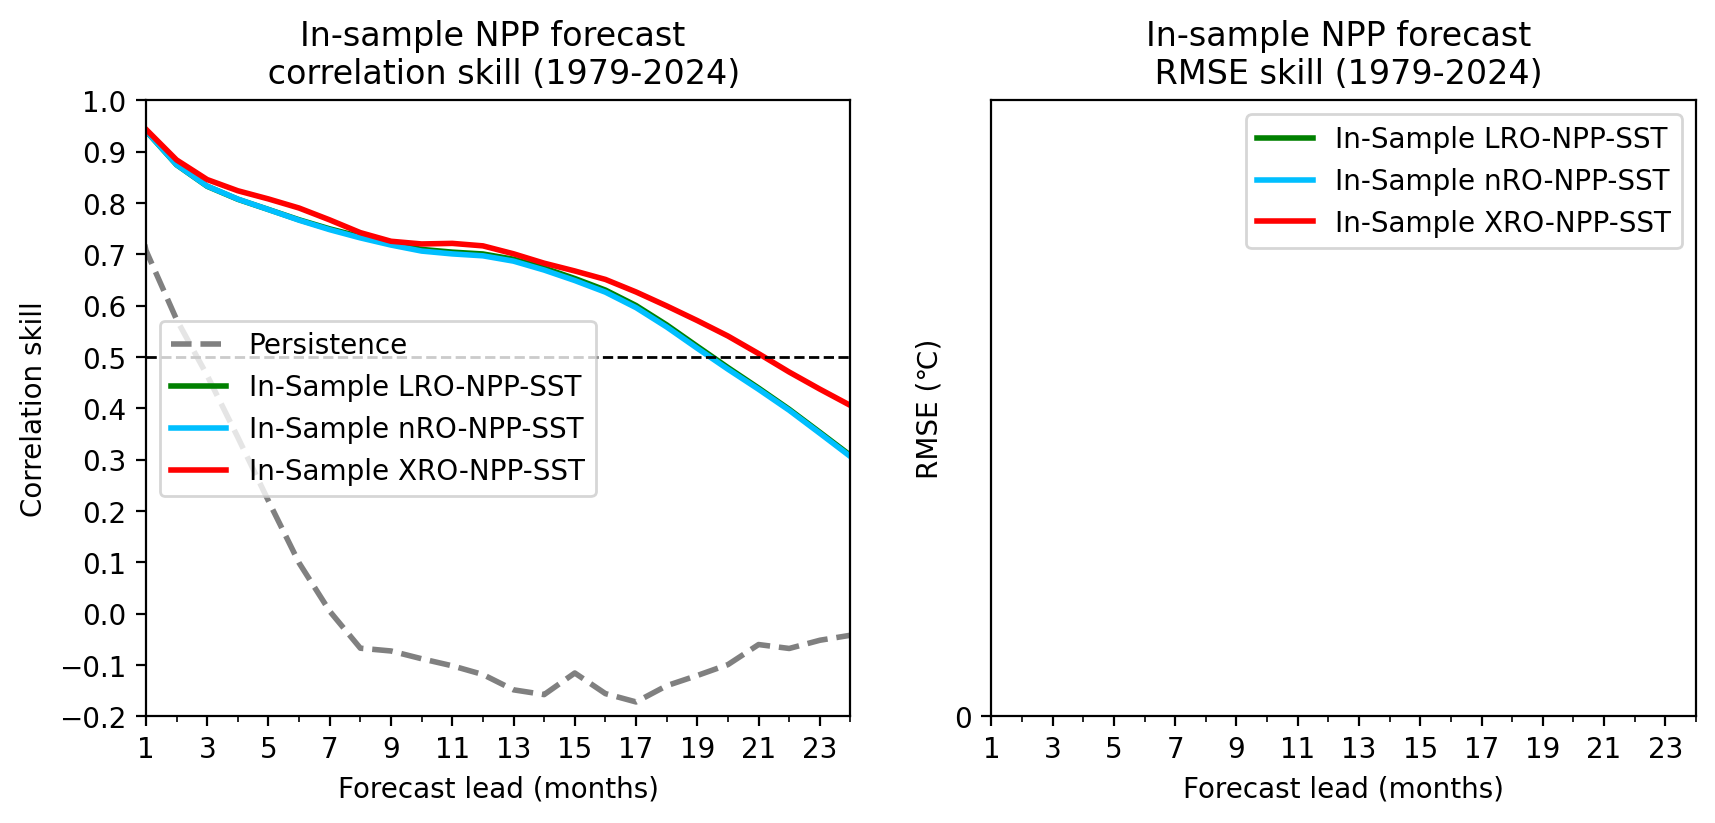

In [38]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 1.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [39]:
XRO_NPP_SST_Fe_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_NPP_SST_Fe_train = XRO_NPP_SST_Fe_ac1.fit_matrix(model_XRO_NPP_SST_Fe_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_SST_Fe_insample_fcst = XRO_NPP_SST_Fe_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_Fe_train, init_ds=model_XRO_NPP_SST_Fe_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_SST_Fe_insample = calc_forecast_skill(XRO_NPP_SST_Fe_insample_fcst, model_XRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_NPP_SST_Fe_insample = calc_forecast_skill(XRO_NPP_SST_Fe_insample_fcst, model_XRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_NPP_SST_Fe_train = XRO_NPP_SST_Fe_ac1.fit_matrix(model_NRO_NPP_SST_Fe_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_SST_Fe_insample_fcst = XRO_NPP_SST_Fe_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_Fe_train, init_ds=model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_SST_Fe_insample = calc_forecast_skill(NRO_NPP_SST_Fe_insample_fcst, model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_NPP_SST_Fe_insample = calc_forecast_skill(NRO_NPP_SST_Fe_insample_fcst, model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_NPP_SST_Fe_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_SST_Fe_train = XRO_NPP_SST_Fe_ac1.fit_matrix(model_NRO_NPP_SST_Fe_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_SST_Fe_insample_fcst = XRO_NPP_SST_Fe_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_Fe_train, init_ds=model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_SST_Fe_insample = calc_forecast_skill(LRO_NPP_SST_Fe_insample_fcst, model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_NPP_SST_Fe_insample = calc_forecast_skill(LRO_NPP_SST_Fe_insample_fcst, model_NRO_NPP_SST_Fe_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

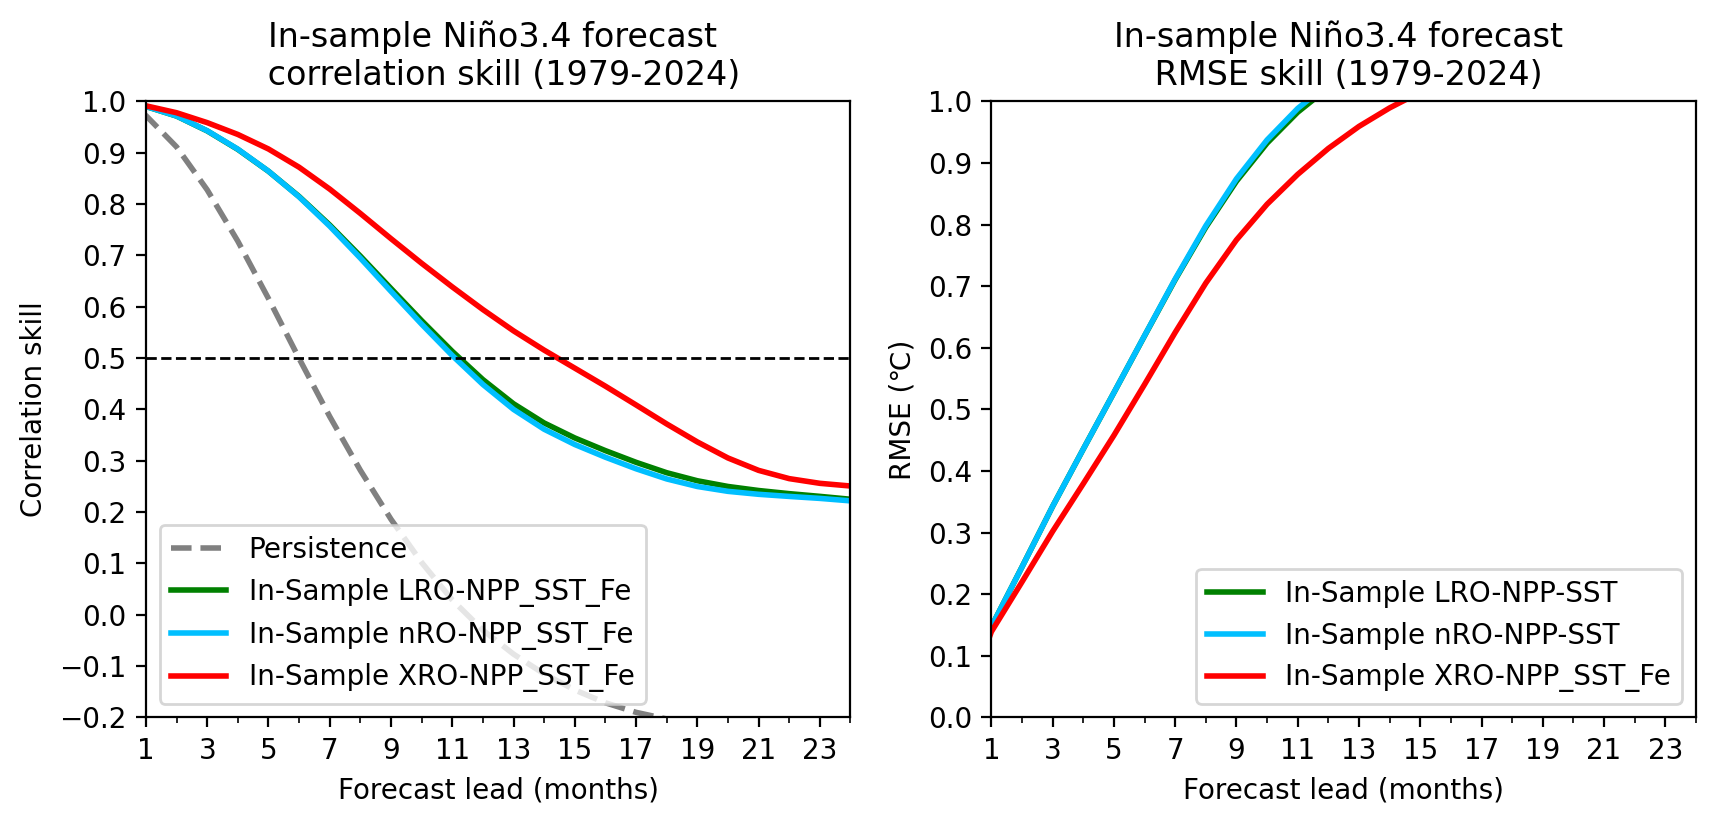

In [40]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_SST_Fe', c='green', lw=2)
acc_NRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_SST_Fe', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_Fe', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_Fe', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


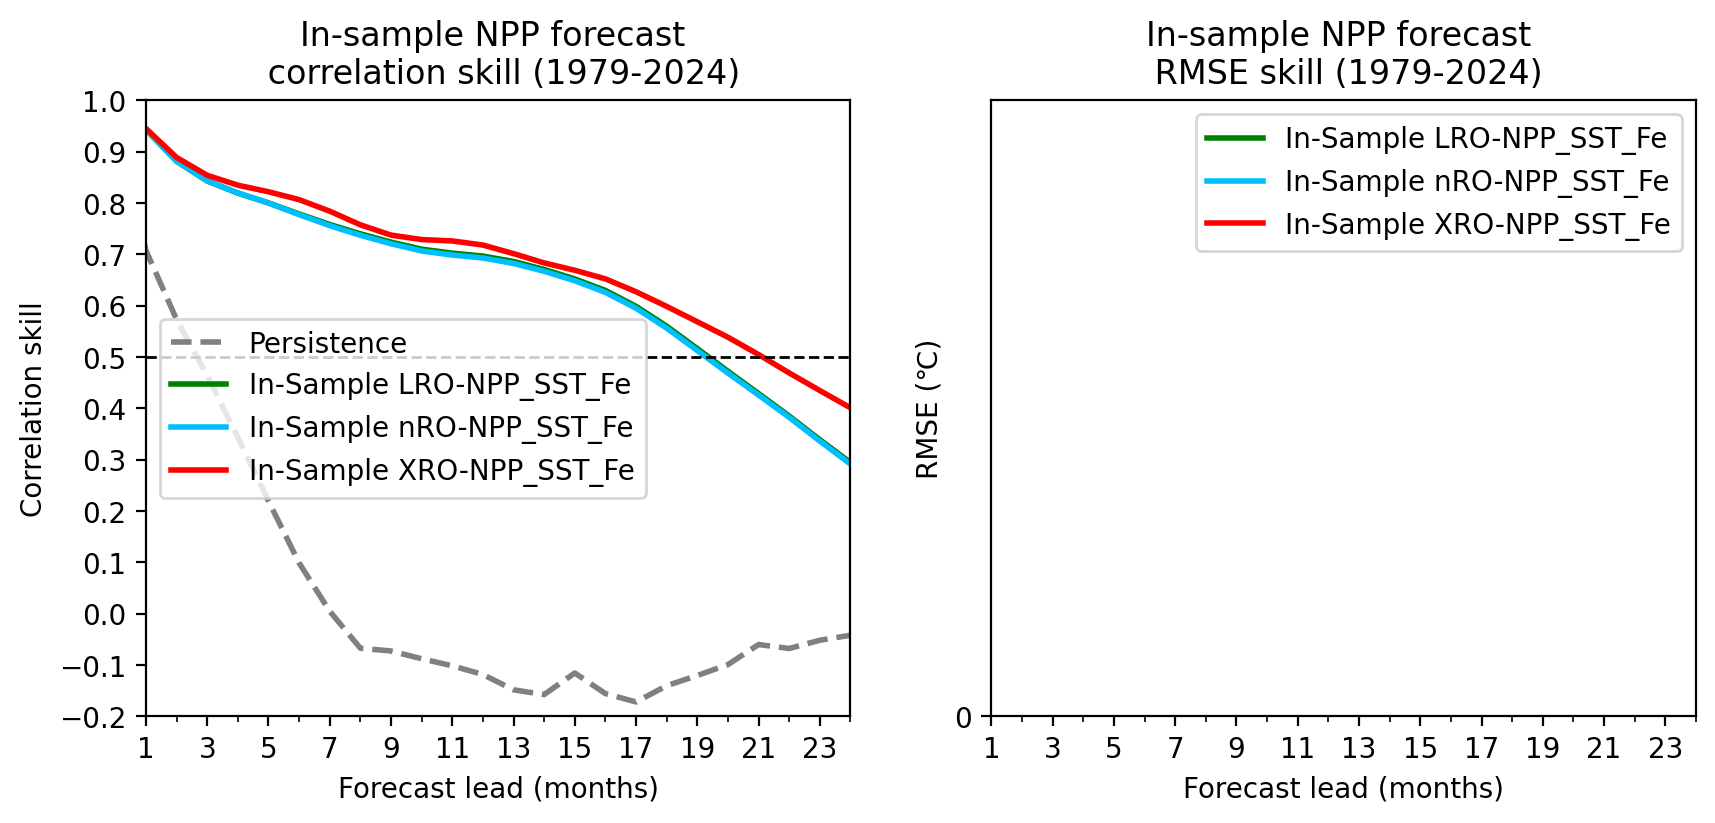

In [41]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_SST_Fe', c='green', lw=2)
acc_NRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_SST_Fe', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_Fe', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_SST_Fe', c='green', lw=2)
rmse_NRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_SST_Fe', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_Fe_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_SST_Fe', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 1.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


In [42]:
slice_train2 = slice('1979-01', '2023-12')

XRO_ALL_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_ALL_train = XRO_ALL_ac1.fit_matrix(model_XRO_ALL_ds.sel(time=slice_train2), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_XRO_ALL_train, init_ds=model_XRO_ALL_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, model_XRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

rmse_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, model_XRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

fit_NRO_ALL_train = XRO_ALL_ac1.fit_matrix(model_NRO_ALL_ds.sel(time=slice_train2), maskNT=['T2'], maskNH=['T2'])
NRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_NRO_ALL_train, init_ds=model_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, model_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, model_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(model_NRO_ALL_ds, maskNT=[], maskNH=[])

fit_LRO_ALL_train = XRO_ALL_ac1.fit_matrix(model_NRO_ALL_ds.sel(time=slice_train2), maskNT=[], maskNH=[])
LRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_LRO_ALL_train, init_ds=model_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, model_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))
rmse_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, model_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1979-01', '2024-12'))

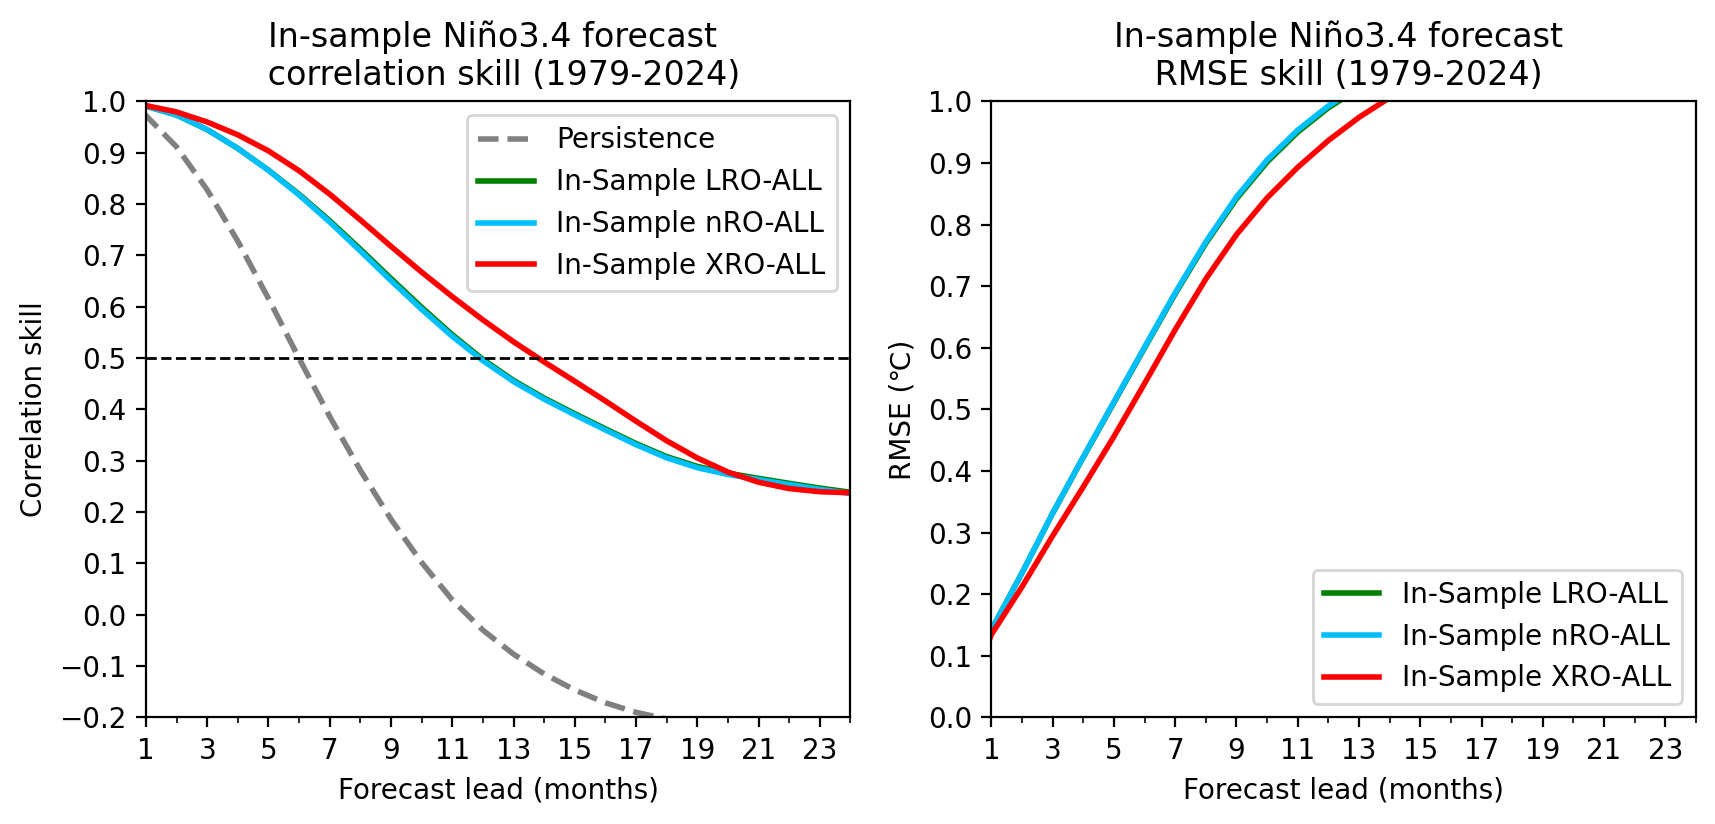

In [43]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()


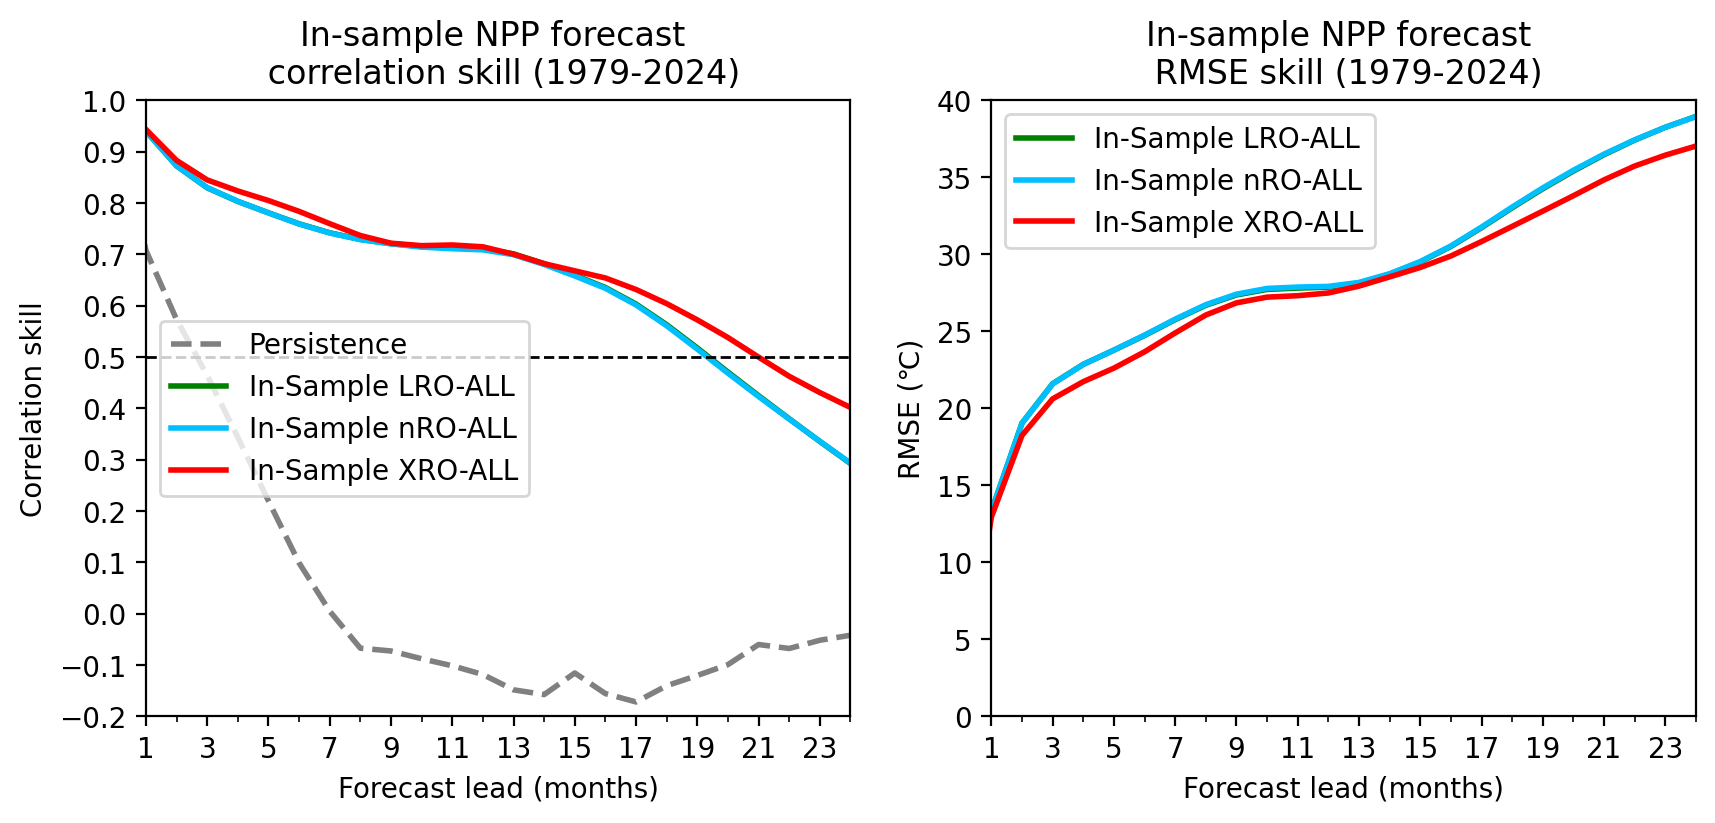

In [60]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 40.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1979-2024)')
ax.legend()


### 5.2 Compare between XRO-NPP and nRO-NPP, ensemble simulations

In [45]:
XRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_train, 
                                              init_ds=model_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_train, 
                                              init_ds=model_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_train, 
                                              init_ds=model_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

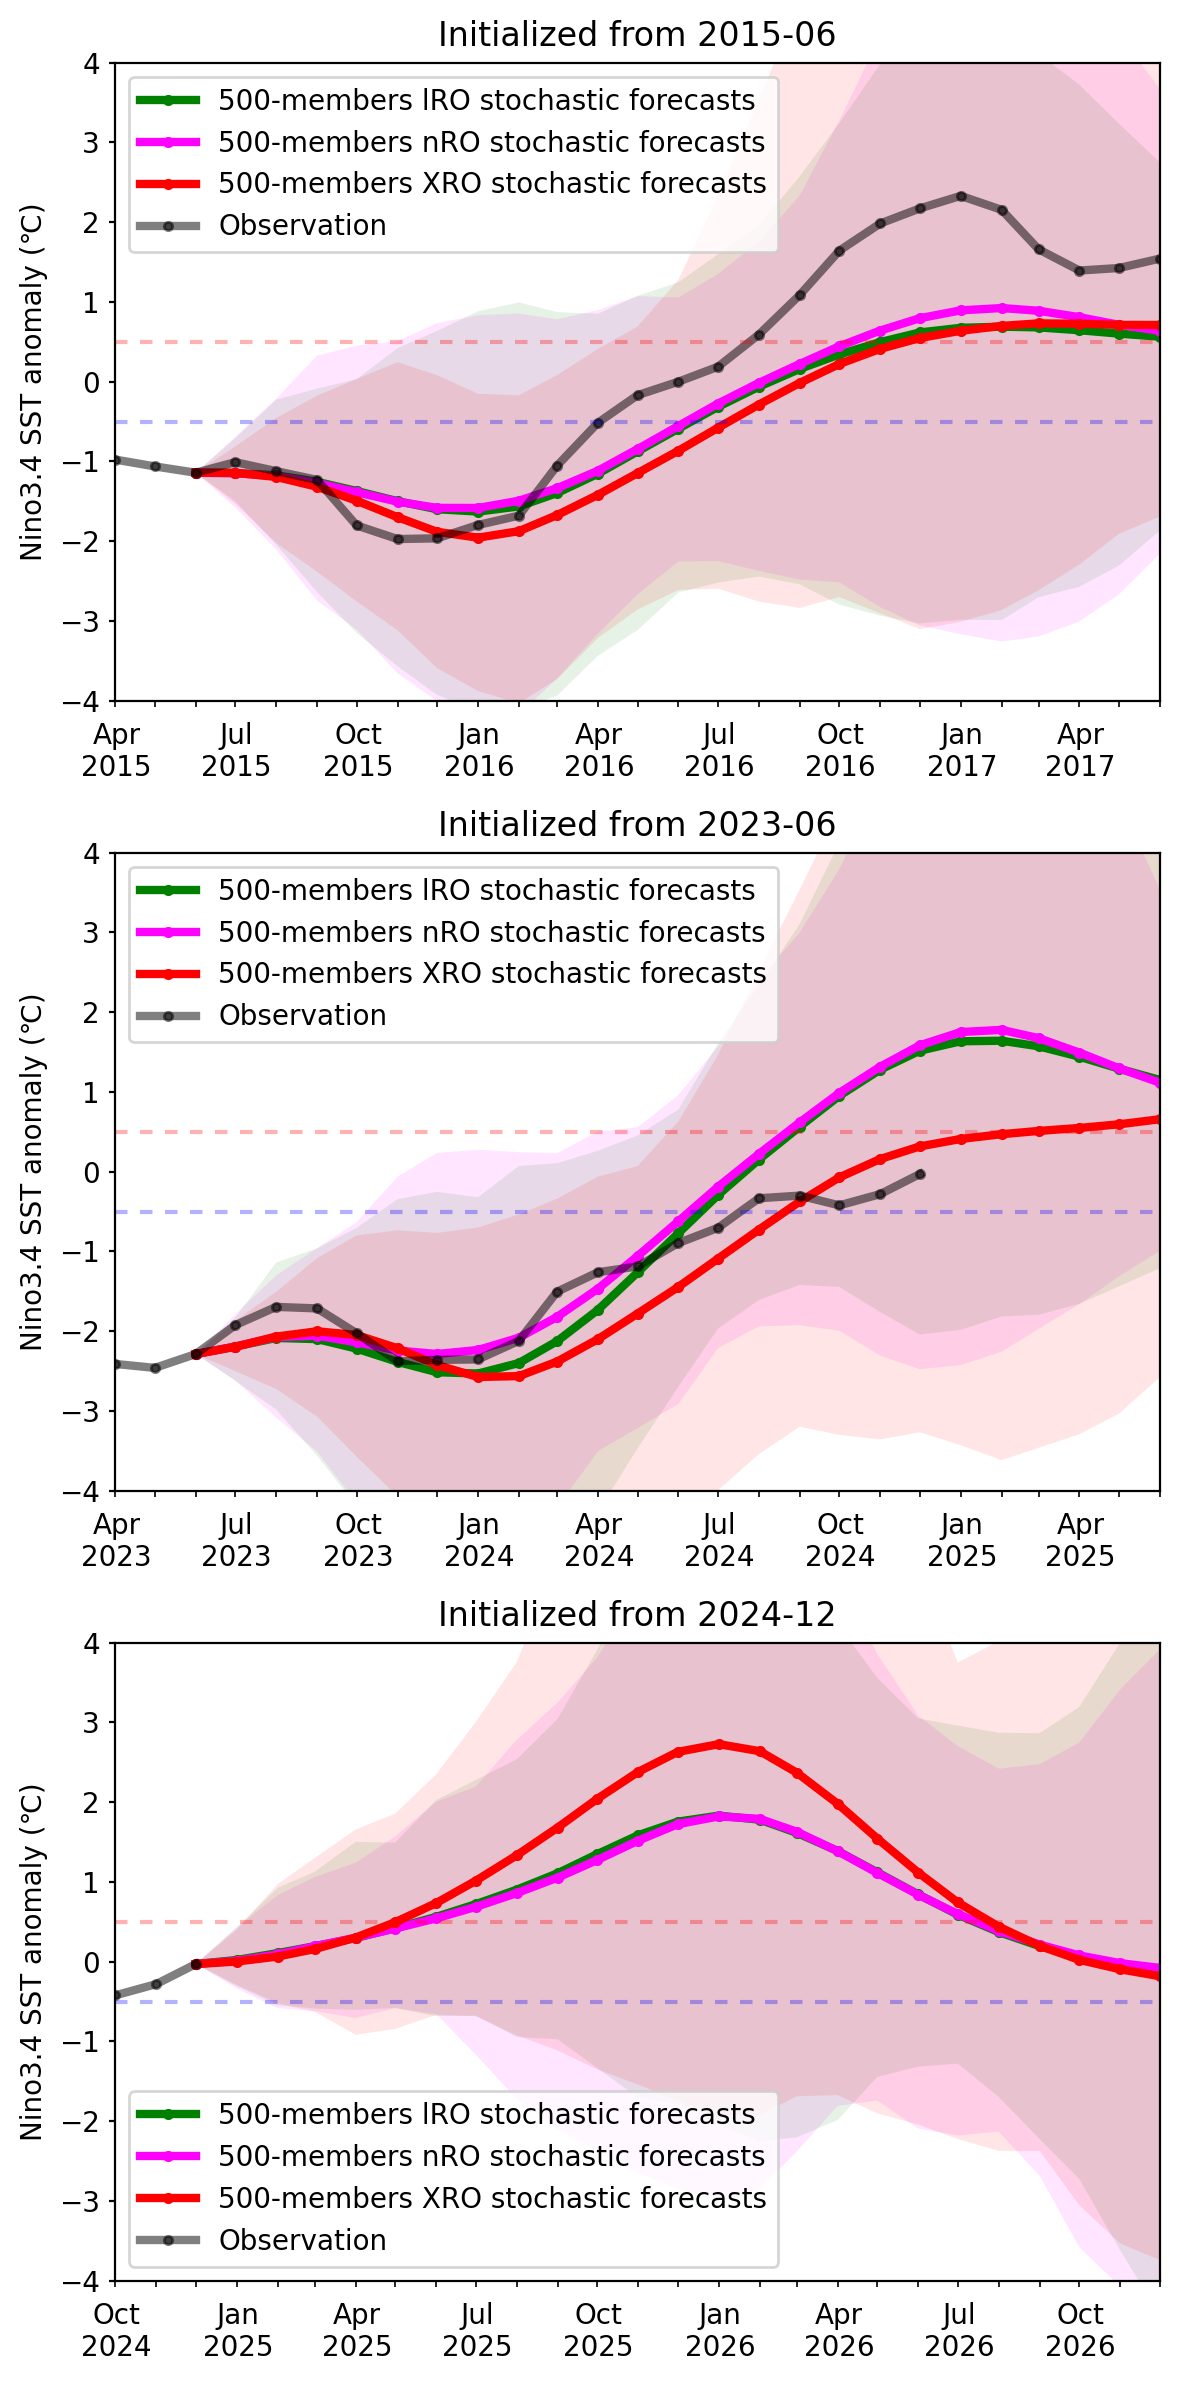

In [46]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [47]:
XRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_ann_train, 
                                              init_ds=model_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_NRO_ann_train, 
                                              init_ds=model_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_LRO_ann_train, 
                                              init_ds=model_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

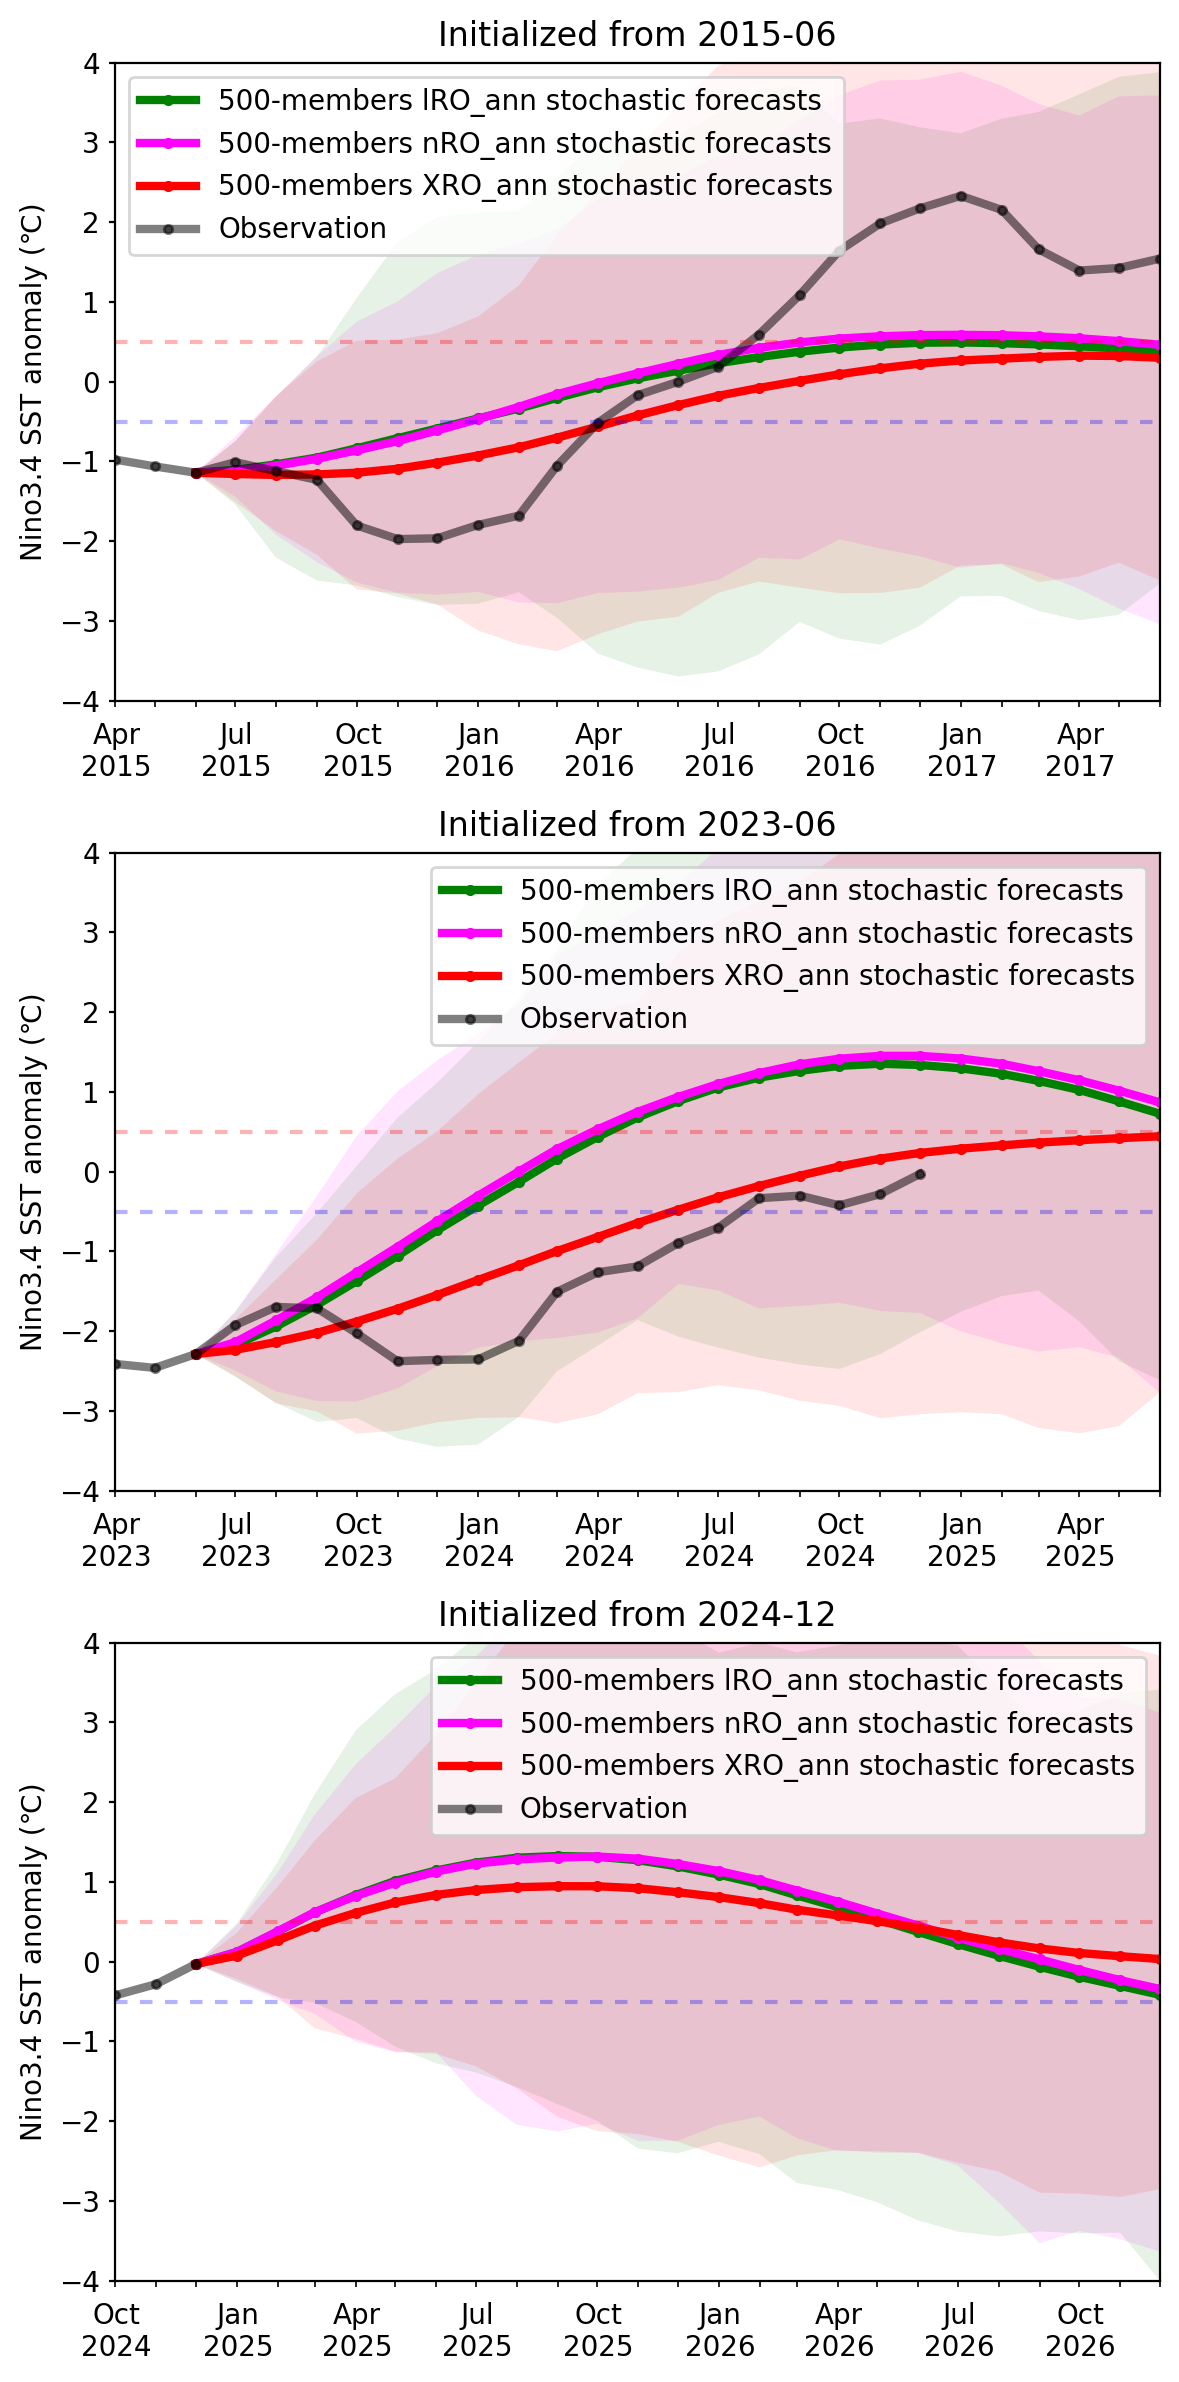

In [48]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [49]:
XRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_train, 
                                              init_ds=model_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_train, 
                                              init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_train, 
                                              init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

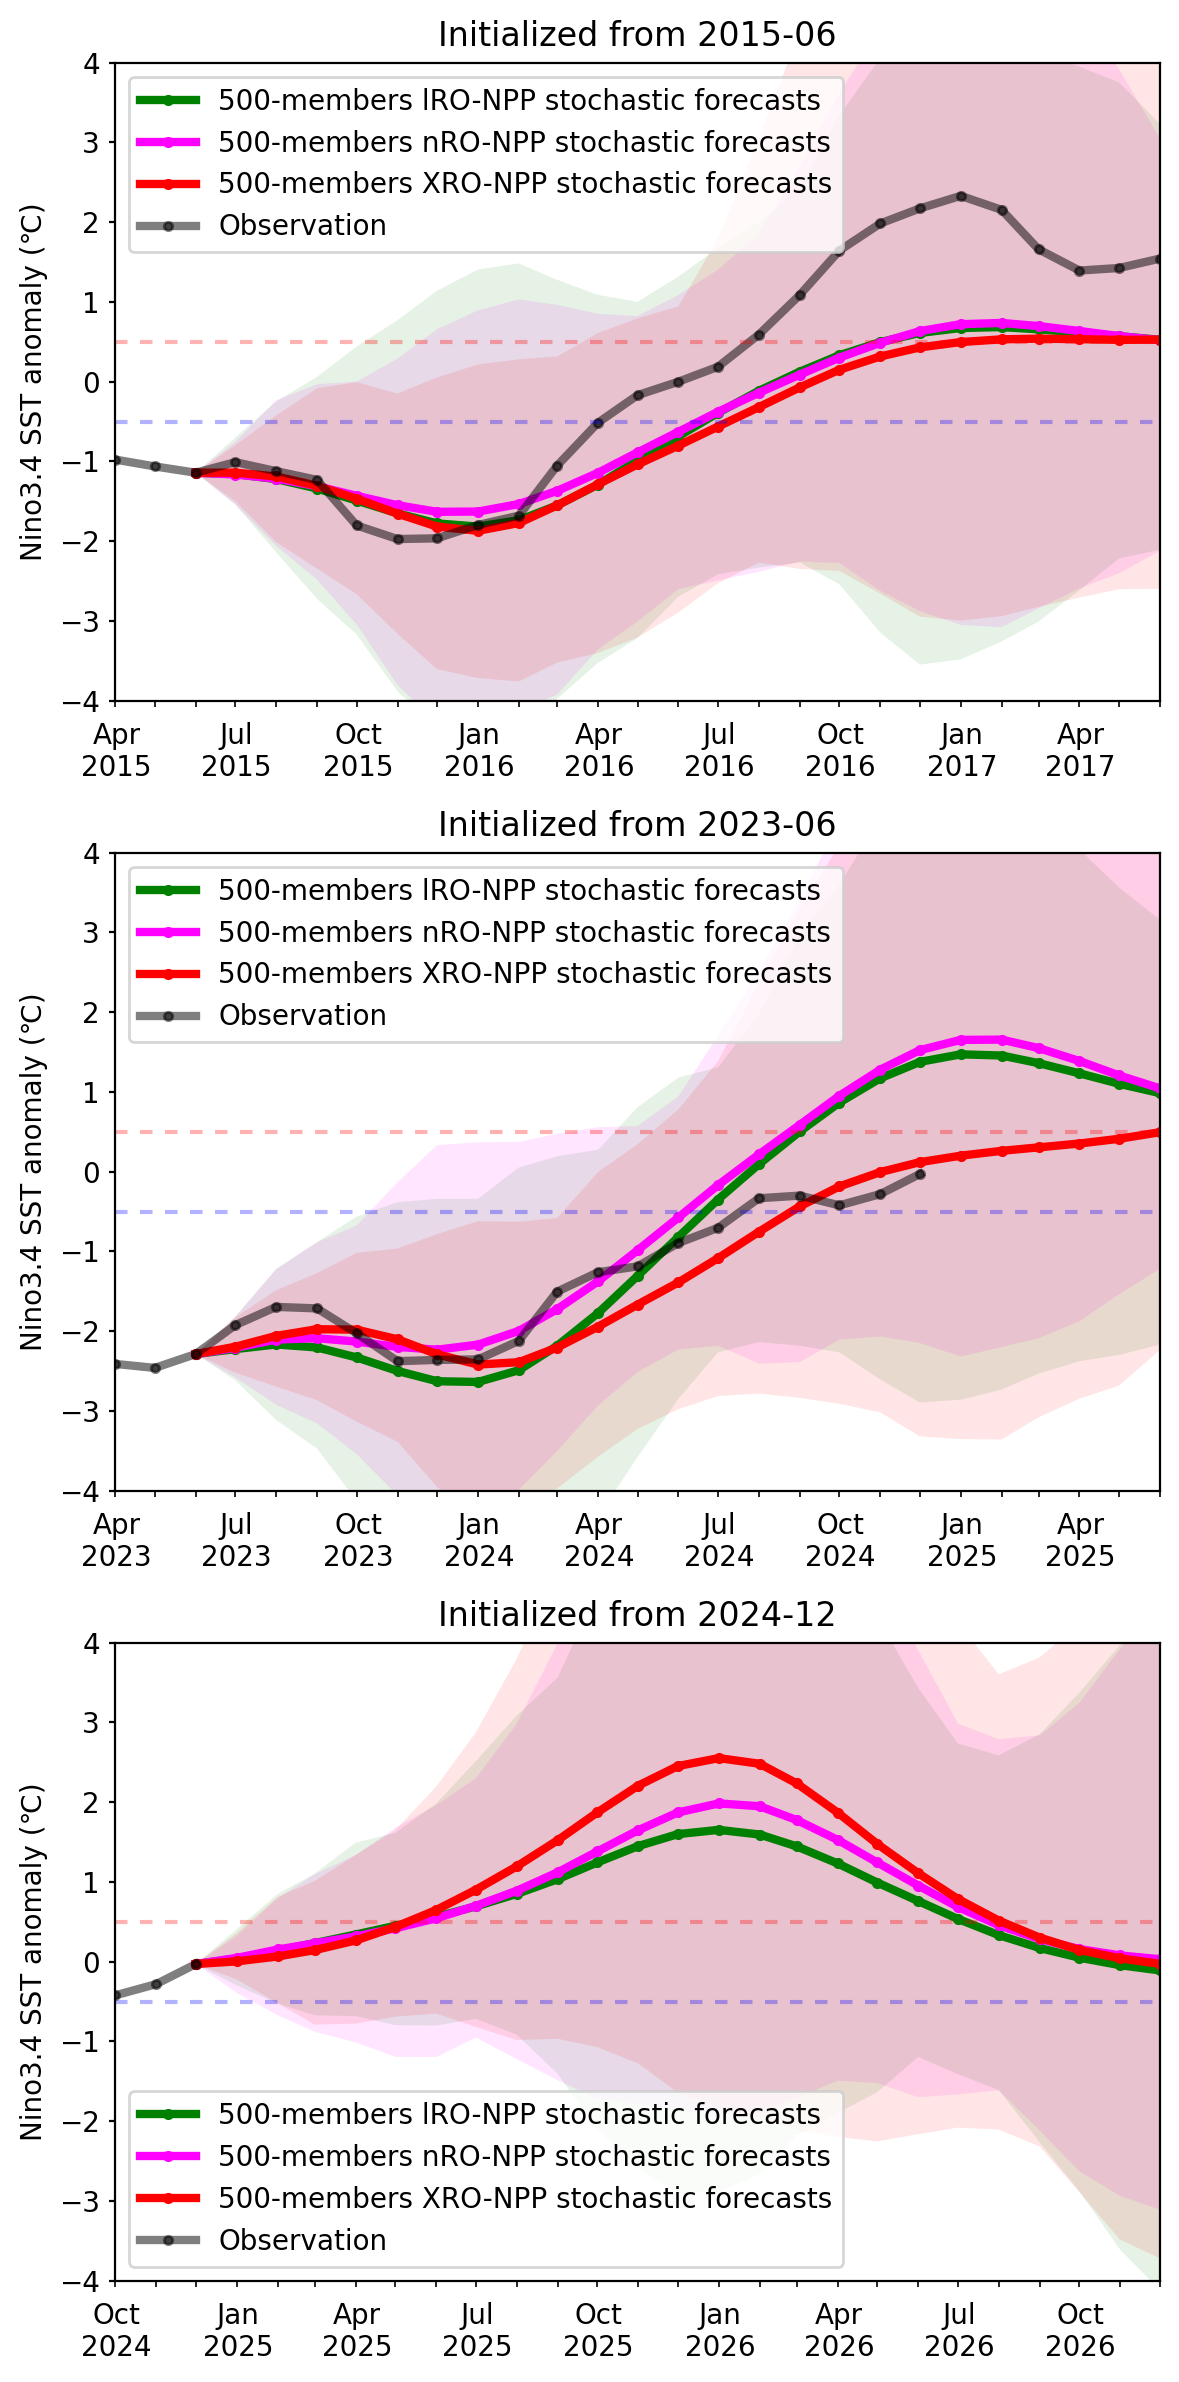

In [50]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

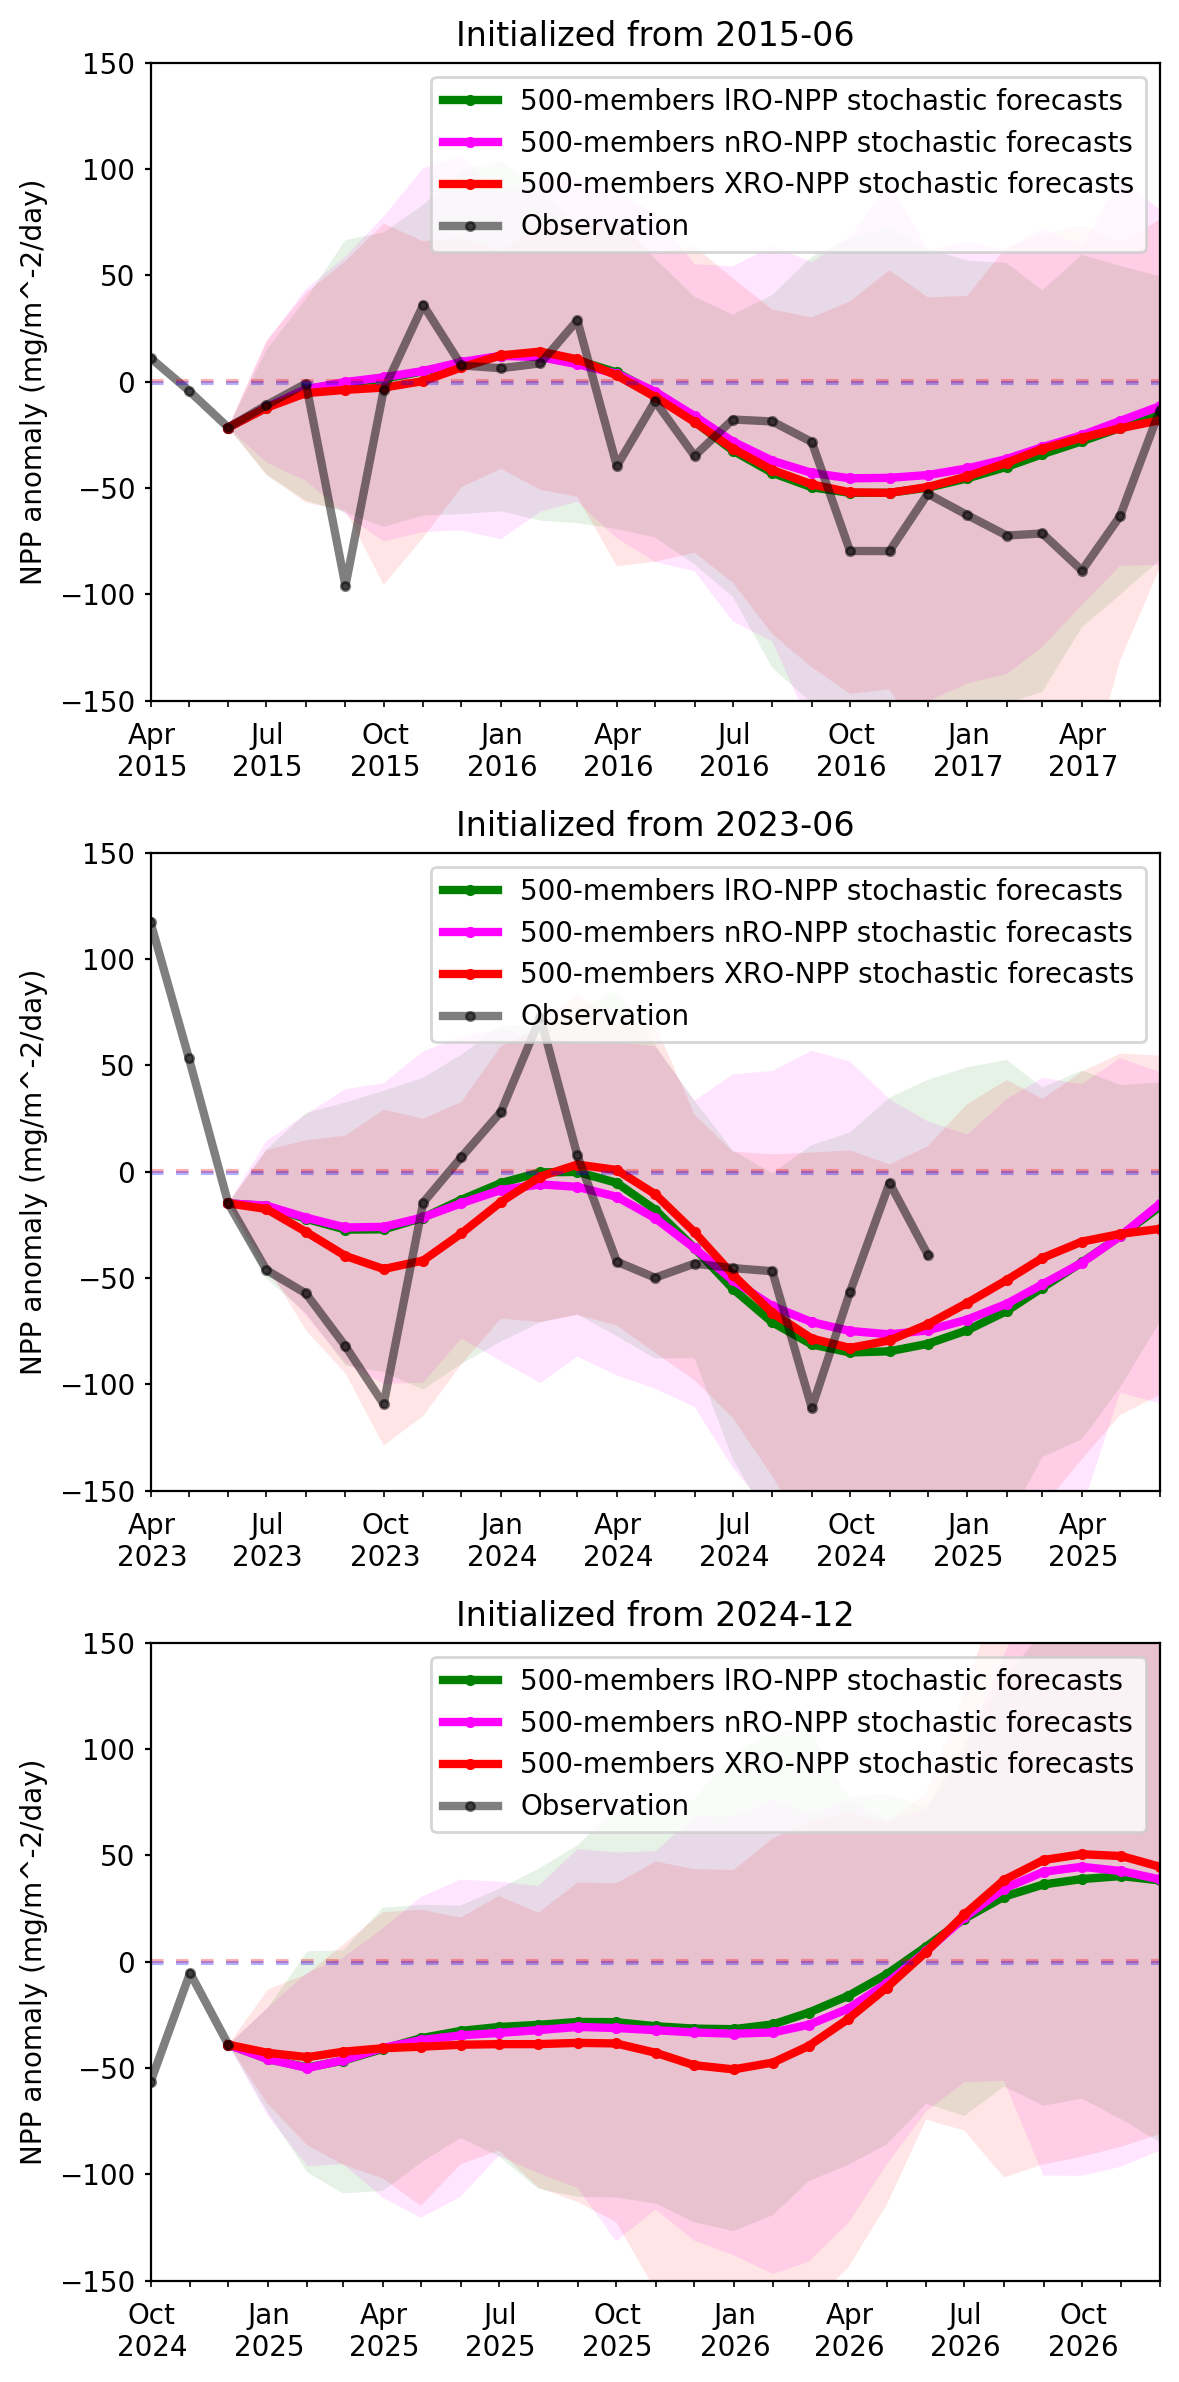

In [51]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('NPP anomaly (mg/m^-2/day)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [52]:
XRO_NPP_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_NPP_ann_train, 
                                              init_ds=model_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [53]:
NRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_ann_train, 
                                              init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [54]:
LRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_ann_train, 
                                              init_ds=model_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

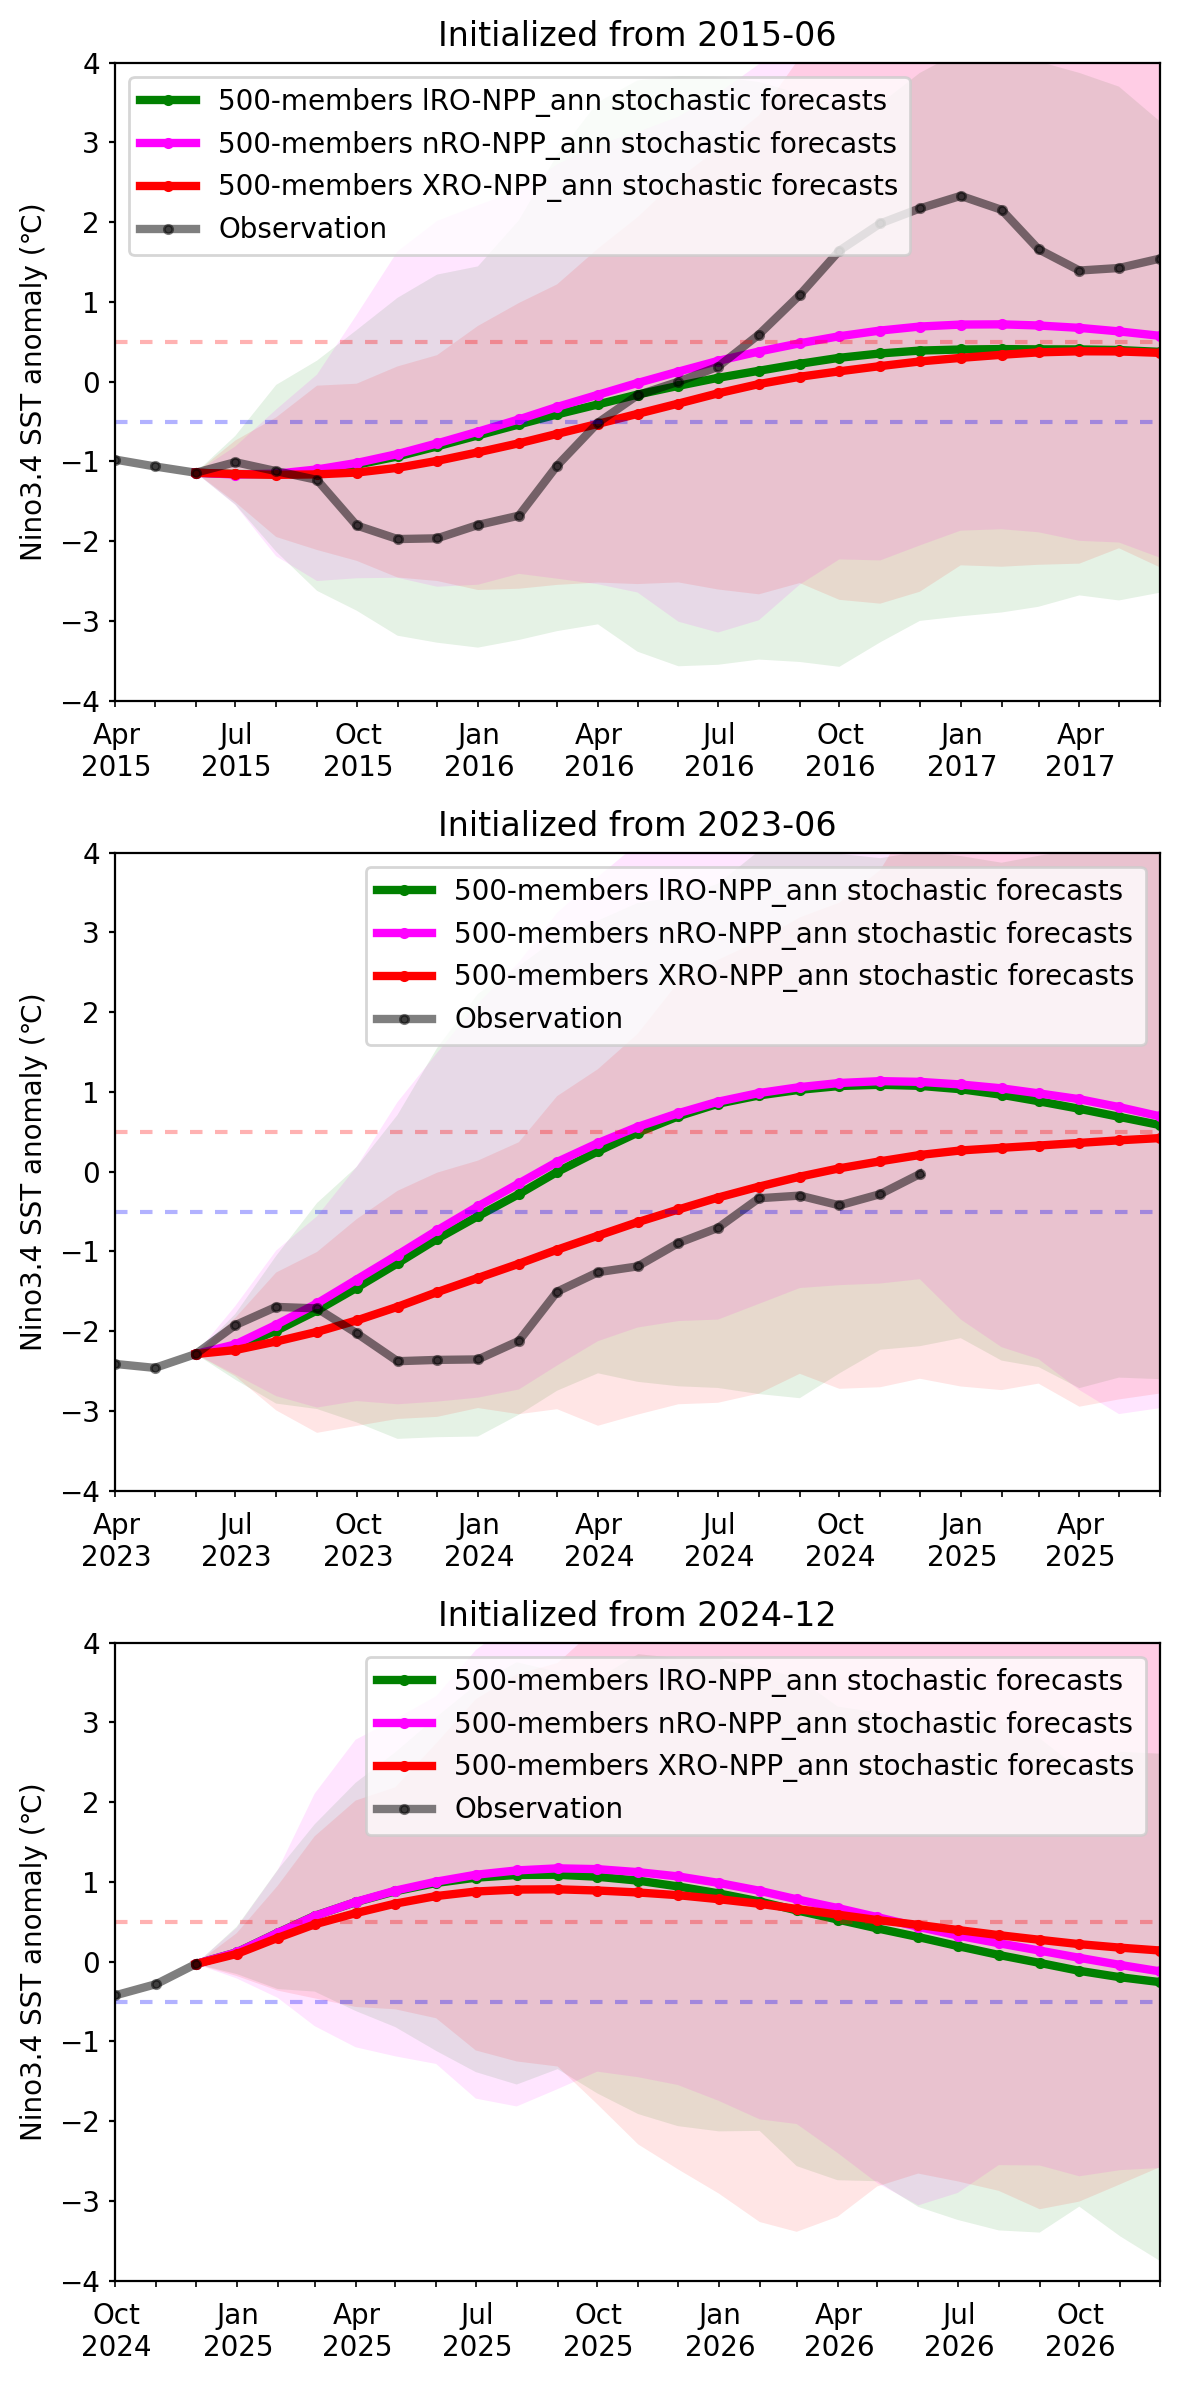

In [55]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

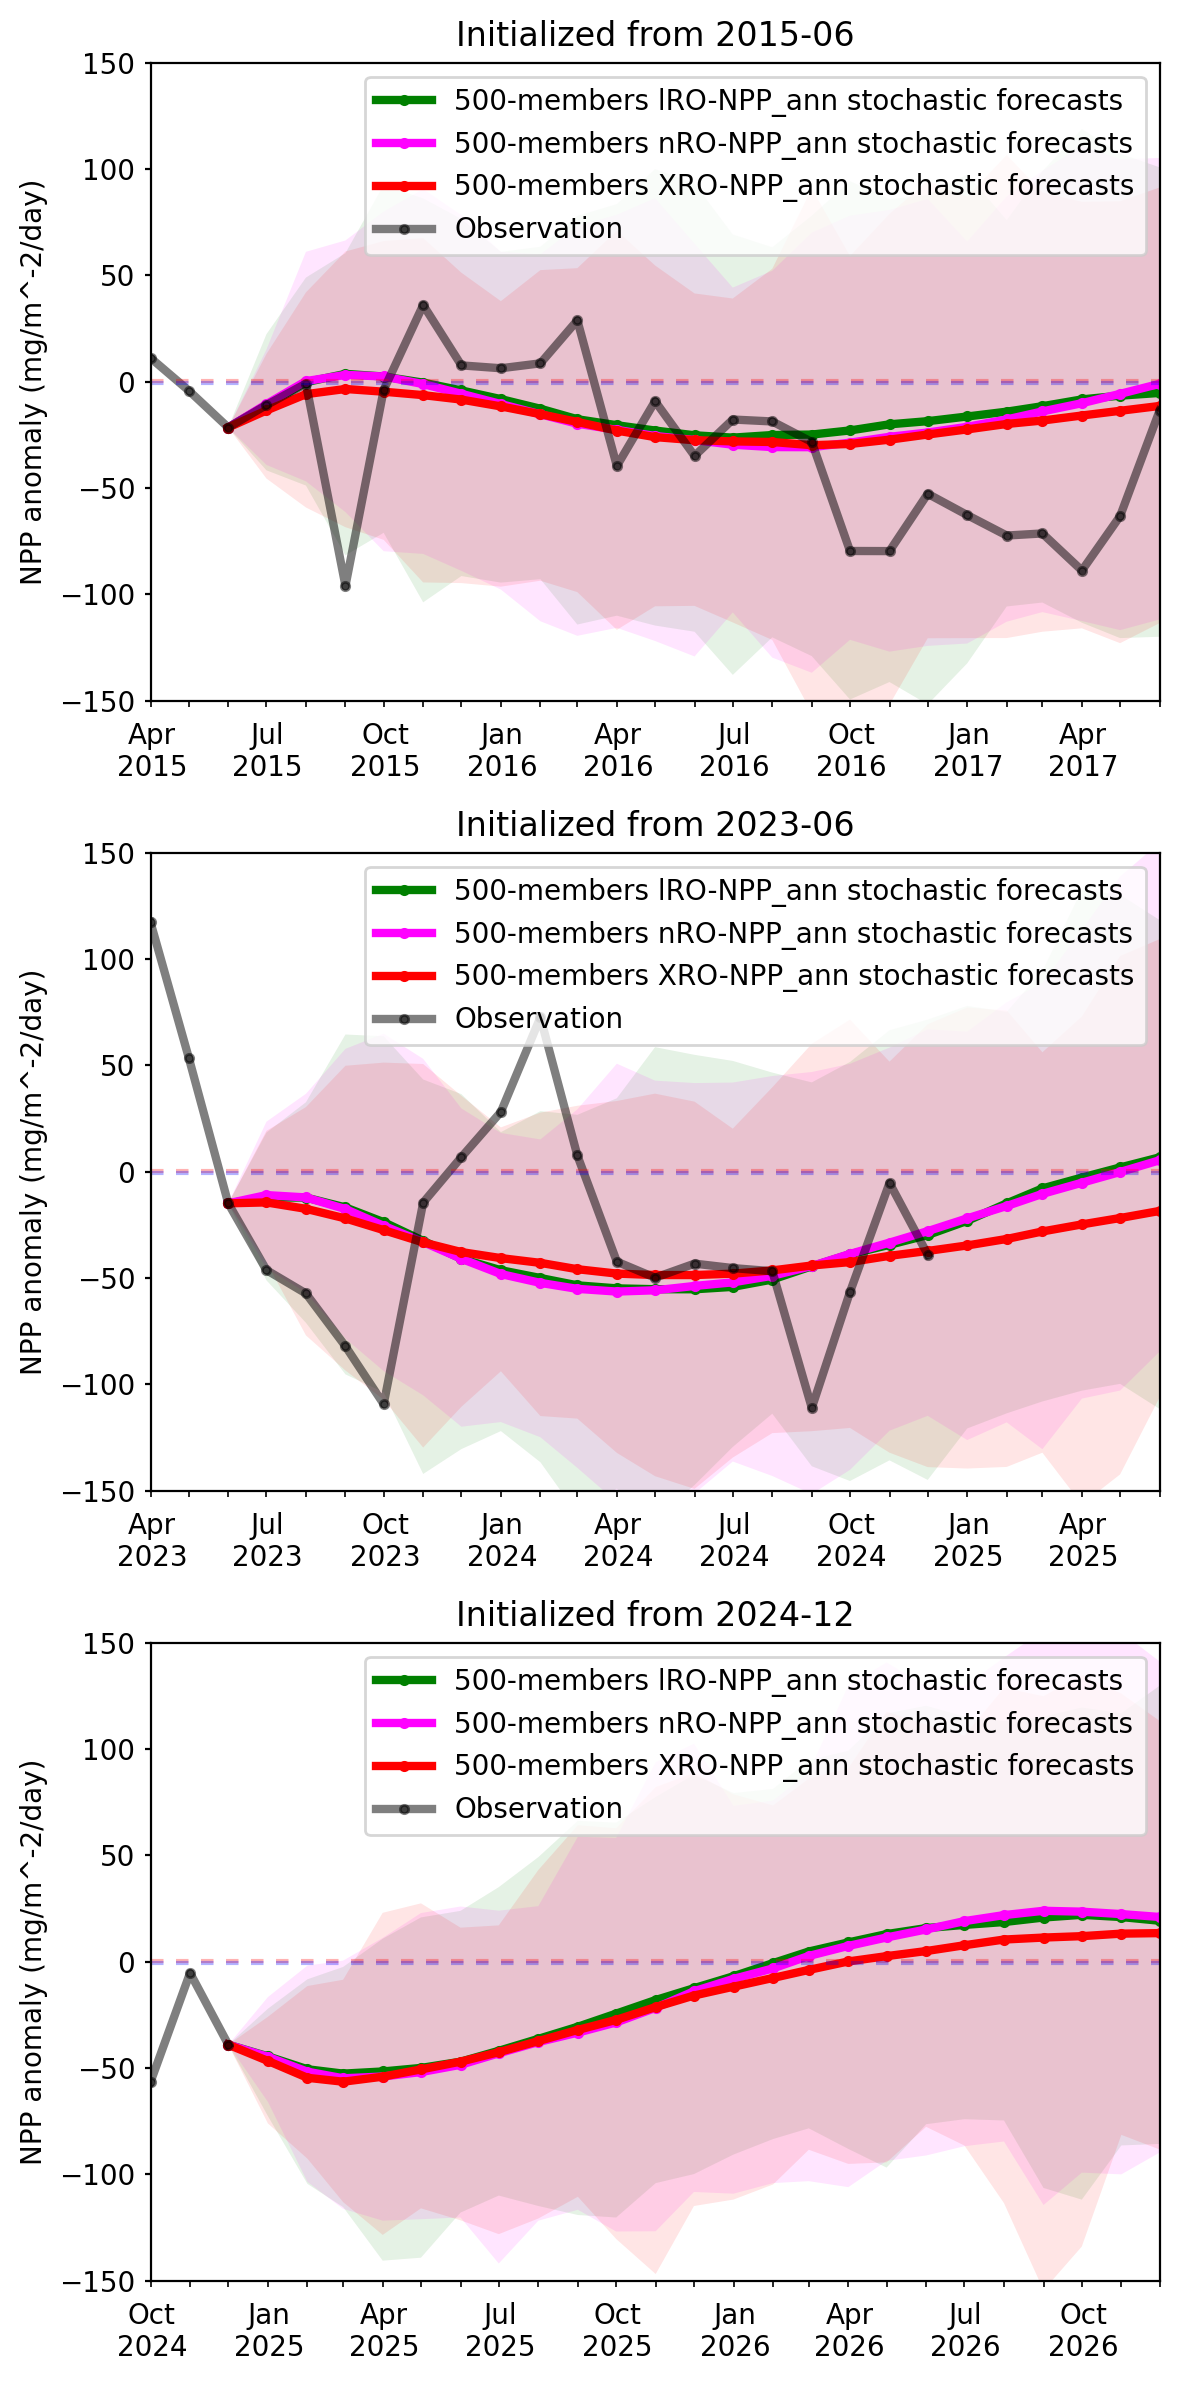

In [56]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('NPP anomaly (mg/m^-2/day)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [57]:
XRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, 
                                              init_ds=model_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, 
                                              init_ds=model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, 
                                              init_ds=model_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

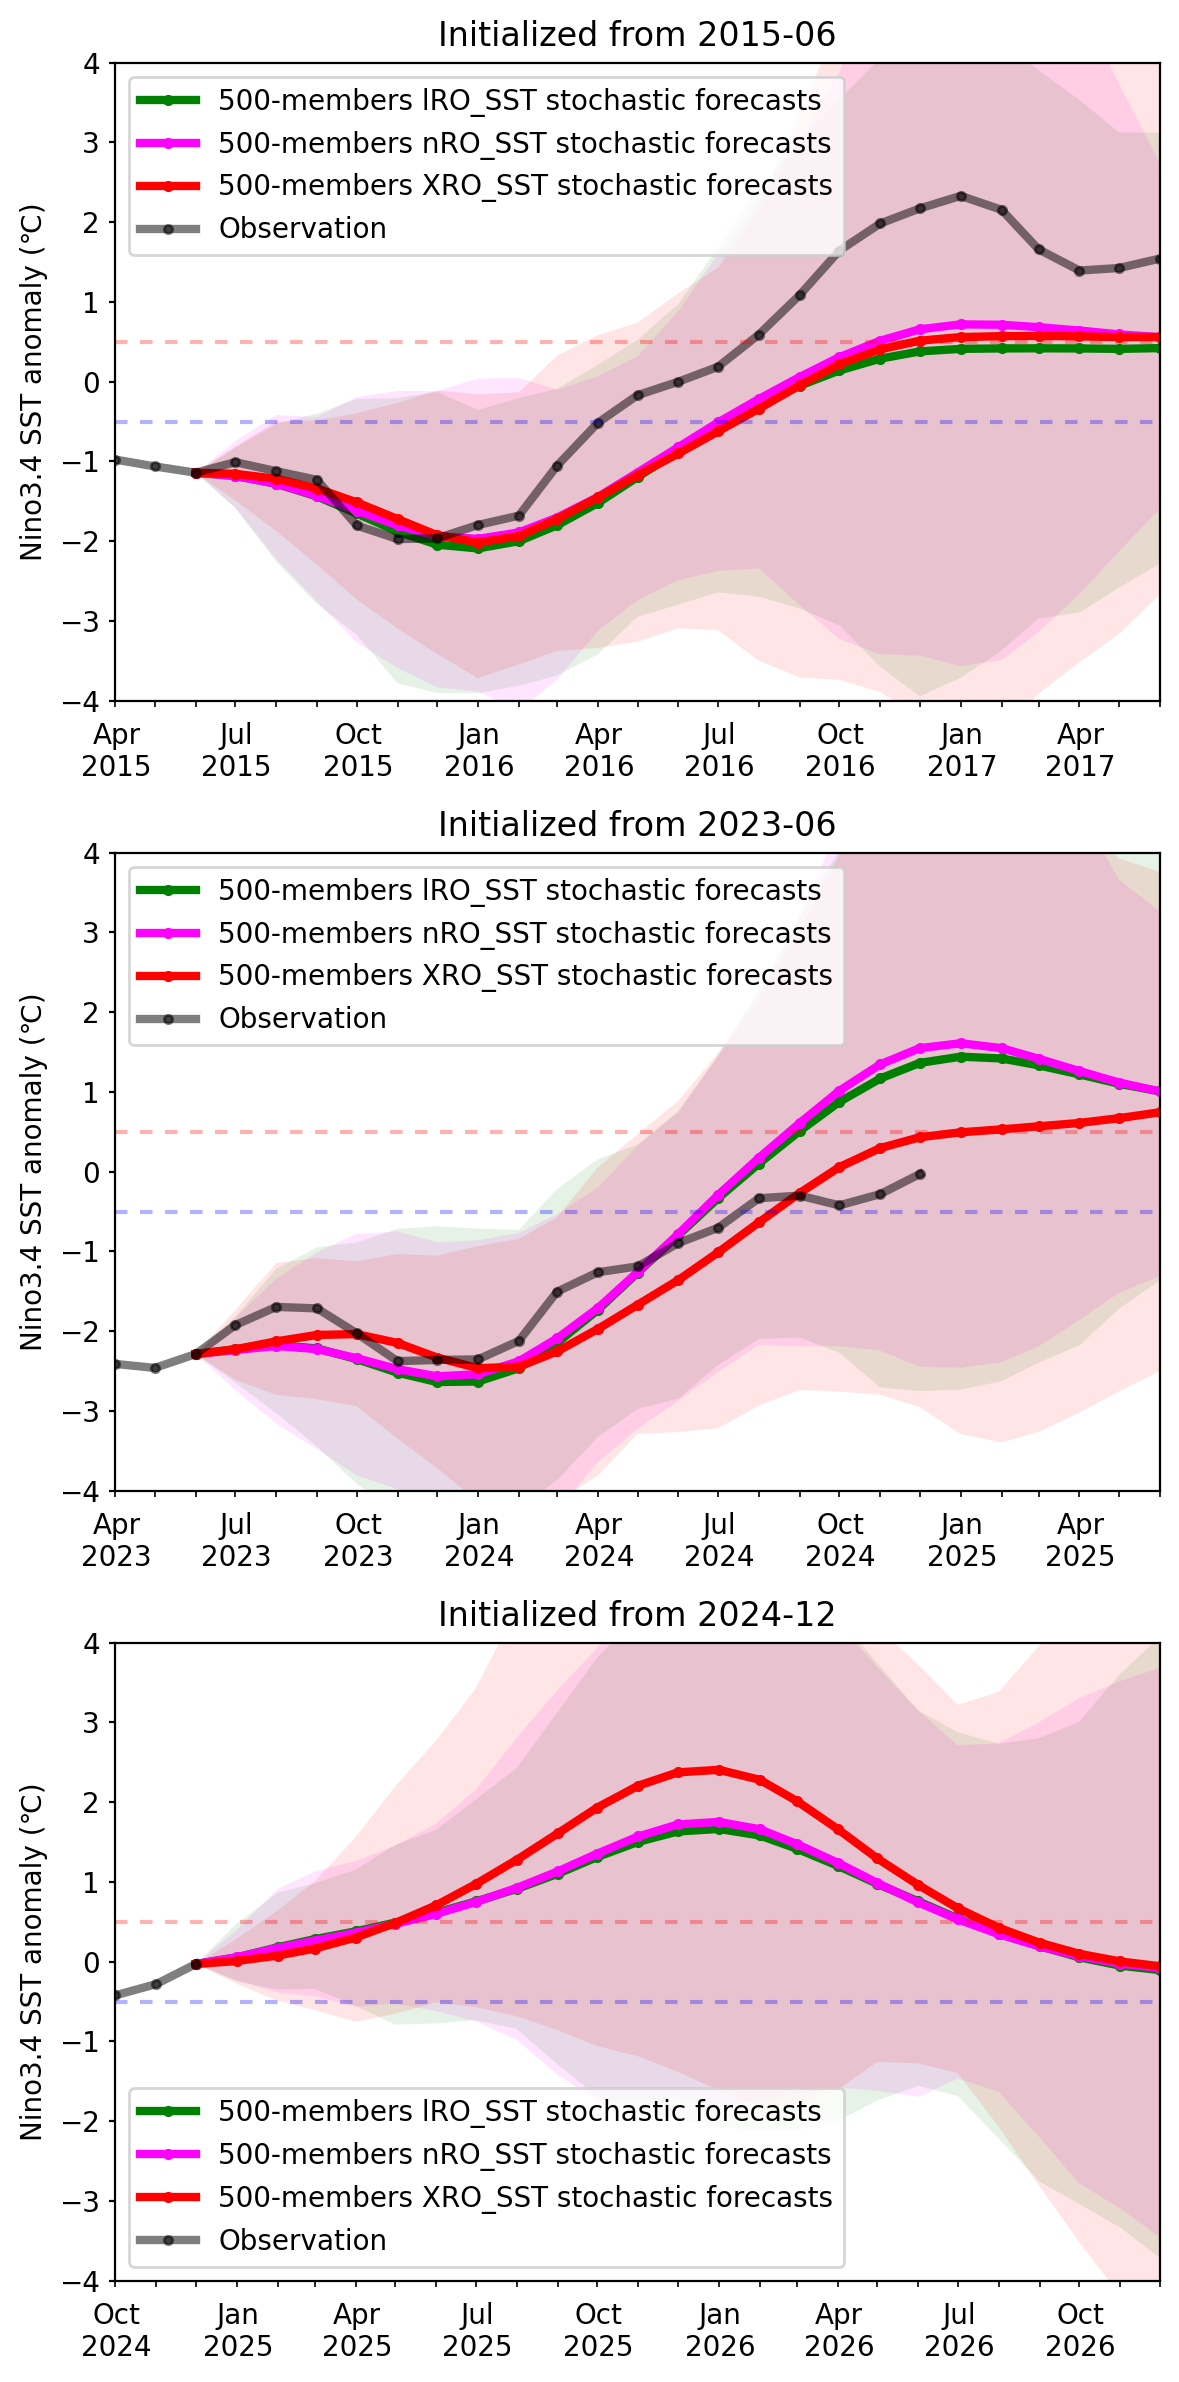

In [58]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_SST_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

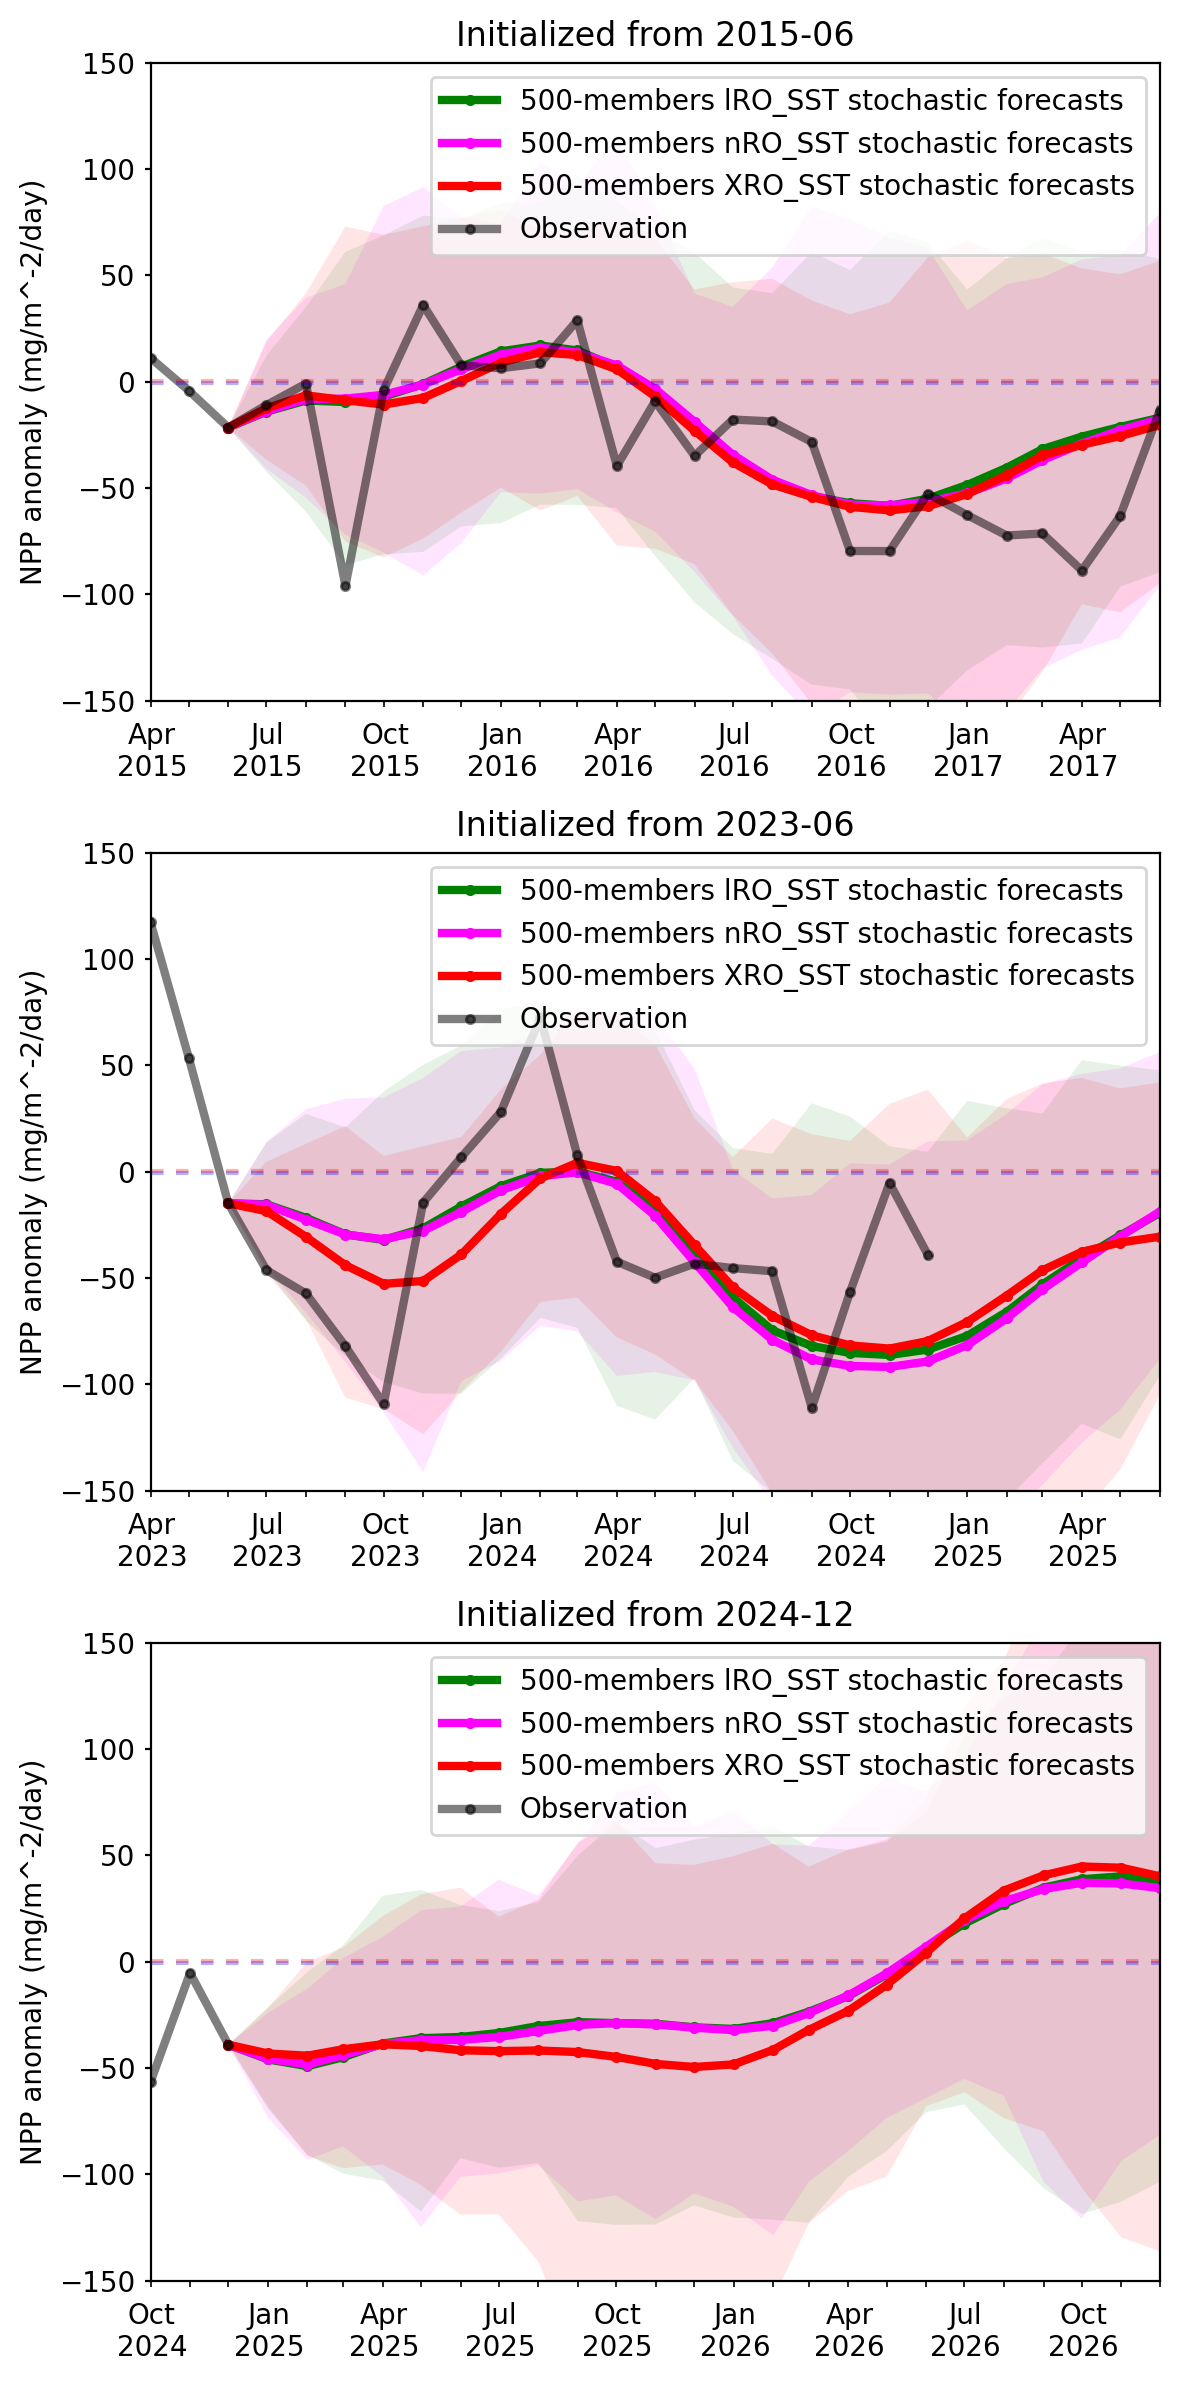

In [59]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = model_XRO_NPP_SST_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('NPP anomaly (mg/m^-2/day)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()